### 05 ML models

In [2]:
# If you see "Failed building wheel for shap" during shap installation,
# please visit https://visualstudio.microsoft.com/visual-cpp-build-tools/, 
# download and run the installer, 
# then select the "C++ build tools" option and complete the installation.
# Afterward, you can install shap successfully.

%pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q imblearn
%pip install -q seaborn
%pip install -q scikit-learn
%pip install -q xgboost
%pip install -q hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score 

import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import shap

In [2]:
# Function for feature scaling
def apply_scaling(sc, X_train, X_test, scaling_list):
  int_cols = X_train.drop(columns=scaling_list).columns.tolist()
  int_train = X_train[int_cols]
  int_test = X_test[int_cols]

  float_cols = X_train[scaling_list].columns.to_list()
  float_train = X_train[float_cols]
  float_test = X_test[float_cols]

  scaled_float_train_array = sc.transform(float_train)
  scaled_float_test_array = sc.transform(float_test)

  scaled_float_train = pd.DataFrame(scaled_float_train_array, 
                                    columns=float_cols, 
                                    index=float_train.index)
  scaled_float_test = pd.DataFrame(scaled_float_test_array, 
                                   columns=float_cols, 
                                   index=float_test.index)

  scaled_train = pd.concat([int_train, scaled_float_train], axis=1)
  scaled_test = pd.concat([int_test, scaled_float_test], axis=1)

  return scaled_train, scaled_test


# Function for one-hot encoding 1
def ohe_manual(df):
  df = df.assign(
      WHITE = (df['RACE_CATEGORY'] == 1).astype(int),
      BLACK = (df['RACE_CATEGORY'] == 2).astype(int),
      ASIAN = (df['RACE_CATEGORY'] == 3).astype(int),
      OTHER_RACE = (df['RACE_CATEGORY'] == 4).astype(int)
  )

  df = df.assign(
      MARRIED = (df['MAR_CATEGORY'] == 1).astype(int),
      SEPARATED = (df['MAR_CATEGORY'] == 2).astype(int),
      NEVER_MARRIED = (df['MAR_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      HUD_HOU = (df['HUD_CATEGORY'] == 1).astype(int),
      HUD_HCV = (df['HUD_CATEGORY'] == 2).astype(int),
      HUD_NON = (df['HUD_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      ONE_FAMILY_HOUSE = (df['UNIT_CATEGORY'] == 1).astype(int),
      APARTMENT = (df['UNIT_CATEGORY'] == 2).astype(int),
      MOBILE_HOUSE = (df['UNIT_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      DIV4_1 = (df['DIV4'] == 1).astype(int),
      DIV4_2 = (df['DIV4'] == 2).astype(int),
      DIV4_3 = (df['DIV4'] == 3).astype(int),
      DIV4_4 = (df['DIV4'] == 4).astype(int)
  )

  return df


# Function for one-hot encoding 2 (education level)
def ohe_manual_edu(df):
  df = df.assign(
      UNDSCHOOL = (df['GRAD_CATEGORY'] == 1).astype(int),
      HIGHSCHOOL = (df['GRAD_CATEGORY'] == 2).astype(int),
      COLLEGE = (df['GRAD_CATEGORY'] == 3).astype(int),
      BACHELOR = (df['GRAD_CATEGORY'] == 4).astype(int),
      MASTER = (df['GRAD_CATEGORY'] == 5).astype(int)
  )

  df = df.assign(
      STAY_0_5 = (df['STAY_CATEGORY'] == 1).astype(int),
      STAY_5_10 = (df['STAY_CATEGORY'] == 2).astype(int),
      STAY_10_MORE = (df['STAY_CATEGORY'] == 3).astype(int)
  )

  return df


# Function for grid-search results
def cv_results(gsearch):
  cv_results_df = pd.concat(
    [pd.DataFrame(gsearch.cv_results_["params"]),
     pd.DataFrame(gsearch.cv_results_["rank_test_accuracy"], 
                  columns=["Rank_ACC"]),
     pd.DataFrame(gsearch.cv_results_["mean_train_accuracy"], 
                  columns=["Train Accuracy"]),
     pd.DataFrame(gsearch.cv_results_["mean_test_accuracy"], 
                  columns=["Valid Accuracy"])
     ], axis=1
  ) 

  if 'rank_test_neg_log_loss' in gsearch.cv_results_.keys():
    cv_results_df = pd.concat(
      [cv_results_df,
       pd.DataFrame(gsearch.cv_results_["rank_test_neg_log_loss"], 
                    columns=["Rank_NLL"]),
       pd.DataFrame(gsearch.cv_results_["mean_train_neg_log_loss"], 
                    columns=["Train Neg. Log Loss"]),
       pd.DataFrame(gsearch.cv_results_["mean_test_neg_log_loss"], 
                    columns=["Valid Neg. Log Loss"])
       ], axis=1
    )

  if 'rank_test_roc_auc_ovr' in gsearch.cv_results_.keys():
    cv_results_df = pd.concat(
      [cv_results_df,
       pd.DataFrame(gsearch.cv_results_["rank_test_roc_auc_ovr"], 
                    columns=["Rank_AUC"]),
       pd.DataFrame(gsearch.cv_results_["mean_train_roc_auc_ovr"], 
                    columns=["Train ROC AUC"]),
       pd.DataFrame(gsearch.cv_results_["mean_test_roc_auc_ovr"], 
                    columns=["Valid ROC AUC"])
       ], axis=1
    )

  cv_results_df['diff_ACC'] = \
    cv_results_df['Train Accuracy'] - cv_results_df['Valid Accuracy']

  if 'rank_test_neg_log_loss' in gsearch.cv_results_.keys():
    cv_results_df['diff_NLL'] = \
      cv_results_df['Train Neg. Log Loss'] - cv_results_df['Valid Neg. Log Loss']

  if 'rank_test_roc_auc_ovr' in gsearch.cv_results_.keys():
    cv_results_df['diff_AUC'] = \
      cv_results_df['Train ROC AUC'] - cv_results_df['Valid ROC AUC']

  return cv_results_df


# Function for evaluation metric plots
def eval_plot(cv_results_df, col, col_name):
  dftmp = cv_results_df
  x_axis = dftmp[col]

  if "Train Neg. Log Loss" not in dftmp.columns:
    plt.plot(x_axis, dftmp["Train Accuracy"], label='Train Accuracy')
    plt.plot(x_axis, dftmp["Valid Accuracy"], label='Valid Accuracy')
    plt.xlabel(col_name)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {col_name}')
    plt.legend()
    plt.grid(True)

  else:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(x_axis, dftmp["Train Accuracy"], label='Train Accuracy')
    plt.plot(x_axis, dftmp["Valid Accuracy"], label='Valid Accuracy')
    plt.xlabel(col_name)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {col_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(x_axis, dftmp["Train Neg. Log Loss"], label='Train Neg. Log Loss')
    plt.plot(x_axis, dftmp["Valid Neg. Log Loss"], label='Valid Neg. Log Loss')
    plt.xlabel(col_name)
    plt.ylabel('Neg. Log Loss')
    plt.title(f'Neg. Log Loss vs {col_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(x_axis, dftmp["Train ROC AUC"], label='Train ROC AUC')
    plt.plot(x_axis, dftmp["Valid ROC AUC"], label='Valid ROC AUC')
    plt.xlabel(col_name)
    plt.ylabel('ROC AUC')
    plt.title(f'ROC AUC vs {col_name}')
    plt.legend()
    plt.grid(True)

  plt.tight_layout()
  plt.show()


# Function for model report1
def report_for_model1(model, X_train, y_train, X_test, y_test):
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  print("\n--- Classification Report for Training Set ---")
  print(classification_report(y_train, train_pred, zero_division=0))
  print("\n--- Classification Report for Testing Set ---")
  print(classification_report(y_test, test_pred, zero_division=0))

  return train_pred, test_pred


# Function for model report2
def report_for_model2(model, X_train, y_train, X_test, y_test):
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  report_train = classification_report(y_train, train_pred, output_dict=True, zero_division=0)
  report_train_df = pd.DataFrame(report_train).transpose()
  report_train_df = report_train_df.round(5)

  report_test = classification_report(y_test, test_pred, output_dict=True, zero_division=0)
  report_test_df = pd.DataFrame(report_test).transpose()
  report_test_df = report_test_df.round(5)

  print("\n--- Classification Report for Training Set ---")
  print(report_train_df)
  print("\n--- Classification Report for Testing Set ---")
  print(report_test_df)


# Function for ROC AUC scores
def print_auc_scores(model, y_test, X_test):
  print("\n--- Area Under the Receiver Operating Characteristic Curve (ROC AUC) for Testing set ---")
  print("None OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                  average=None, multi_class='ovr'))
  print("Macro OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                   average='macro', multi_class='ovr'))
  print("Macro OvO", roc_auc_score(y_test, model.predict_proba(X_test), 
                                   average='macro', multi_class='ovo'))
  print("Weighted OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                      average='weighted', multi_class='ovr'))
  print("Weighted OvO", roc_auc_score(y_test, model.predict_proba(X_test), 
                                      average='weighted', multi_class='ovo'))


# Results of xgboost grid-search
def xgb_cv_results(xgb_clf, xgb_param_grid, d_train, parameter):
  xgb_cv_results = []

  for p in xgb_param_grid[parameter]:
    xgb_clf.set_params(**{parameter: p})

    cv_results = xgb.cv(
      xgb_clf.get_xgb_params(),
      d_train,
      nfold=5,
      num_boost_round=xgb_clf.get_params()['n_estimators'],
      early_stopping_rounds=xgb_clf.get_params()['early_stopping_rounds'],
      seed=seed
    )

    cv_results['diff_merror'] = \
      cv_results['train-merror-mean'] - cv_results['test-merror-mean']
    cv_results['diff_mlogloss'] = \
      cv_results['train-mlogloss-mean'] - cv_results['test-mlogloss-mean']
    cv_results['diff_auc'] = \
      cv_results['train-auc-mean'] - cv_results['test-auc-mean']

    xgb_cv_results.append({
      parameter: p,
      'best_idx_merror': cv_results['test-merror-mean'].idxmin(),
      'best_train_merror': cv_results.loc[cv_results['test-merror-mean'].idxmin(), 
                                          'train-merror-mean'],
      'best_val_merror': cv_results['test-merror-mean'].min(),
      'diff_merror': cv_results.loc[cv_results['test-merror-mean'].idxmin(), 
                                    'diff_merror'],
      'best_idx_mlogloss': cv_results['test-mlogloss-mean'].idxmin(),
      'best_train_mlogloss': cv_results.loc[cv_results['test-mlogloss-mean'].idxmin(), 
                                            'train-mlogloss-mean'],
      'best_val_mlogloss': cv_results['test-mlogloss-mean'].min(),
      'diff_mlogloss': cv_results.loc[cv_results['test-mlogloss-mean'].idxmin(), 
                                      'diff_mlogloss'],
      'best_idx_auc': cv_results['test-auc-mean'].idxmax(),
      'best_train_auc': cv_results.loc[cv_results['test-auc-mean'].idxmax(), 
                                       'train-auc-mean'],
      'best_val_auc': cv_results['test-auc-mean'].max(),
      'diff_auc': cv_results.loc[cv_results['test-auc-mean'].idxmin(), 
                                 'diff_auc'],
      'boost_rounds': cv_results.shape[0]
    })

  return pd.DataFrame(xgb_cv_results)


# Evaluation metric plots for xgboost
def xgb_eval_plots(xgb_cv_results_df):

  dftmp = xgb_cv_results_df
  x_axis = xgb_cv_results_df.index.tolist()

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.plot(x_axis, dftmp['train-merror-mean'], label='Train merror')
  plt.plot(x_axis, dftmp['test-merror-mean'], label='Valid merror')
  plt.xlabel('Boosting Round')
  plt.ylabel('Classification Error Rate')
  plt.title('Classification Error Rate vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(x_axis, dftmp['train-mlogloss-mean'], label='Train mlogloss')
  plt.plot(x_axis, dftmp['test-mlogloss-mean'], label='Valid mlogloss')
  plt.xlabel('Boosting Round')
  plt.ylabel('Log Loss')
  plt.title('Log Loss vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.plot(x_axis, dftmp['train-auc-mean'], label='Train auc')
  plt.plot(x_axis, dftmp['test-auc-mean'], label='Valid auc')
  plt.xlabel('Boosting Round')
  plt.ylabel('ROC AUC') 
  plt.title('ROC AUC vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [6]:
# Load X and y
X = pd.read_pickle('./temp/X.pkl')
y = pd.read_pickle('./temp/y.pkl')

In [3]:
# Set seed
seed = 57

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=seed, 
                                                    stratify=y)

print("\n--- Sizes of the splited data ---")
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)
print("\n--- Class distribution in training set ---")
print(y_train.value_counts())
print("\n--- Class distribution in test set ---")
print(y_test.value_counts())


--- Sizes of the splited data ---
X_train: (17621, 24) y_train: (17621,)
X_test: (4406, 24) y_test: (4406,)

--- Class distribution in training set ---
COMPOSITE_HI2
0    9064
2    3869
1    3466
3    1222
Name: count, dtype: int64

--- Class distribution in test set ---
COMPOSITE_HI2
0    2266
2     967
1     867
3     306
Name: count, dtype: int64


In [9]:
# Setting for standardization for numerical features
scaling_list = ['HH_AGE', 'NUM_MEMBERS', 'INCOME', 'LN_INCOME', 'HOUSE_AGE']

sc = StandardScaler()
sc.fit(X_train[X_train[scaling_list].columns.to_list()])

print("\n--- Feature-types for X_train ---")
print(pd.DataFrame({'No.': list(range(len(X_train.dtypes))),
                    'D.types': X_train.dtypes}))


--- Feature-types for X_train ---
                No.  D.types
RACE_CATEGORY     0    int64
LATIN             1    int64
NON_US_CITIZEN    2    int64
HH_AGE            3  float64
MALE              4    int64
GRAD_CATEGORY     5    int64
MAR_CATEGORY      6    int64
YNGKIDS           7    int64
SENIORS           8    int64
DISABLED          9    int64
NUM_MEMBERS      10    int64
INCOME           11  float64
LN_INCOME        12  float64
STAY_CATEGORY    13    int64
HOUSE_AGE        14  float64
UNIT_CATEGORY    15    int64
NOGOODSCHOOL     16    int64
NOGOODPTRNS      17    int64
HIGH_PCRIME      18    int64
HIGH_SCRIME      19    int64
HIGH_RISK        20    int64
RENT_CONTROL     21    int64
HUD_CATEGORY     22    int64
DIV4             23    int64


In [10]:
# Undersampling
rus = RandomUnderSampler(
    sampling_strategy={y_train.value_counts().index[0]: y_train.value_counts().iloc[1]}, 
    random_state=seed
)

X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("\n--- The number of each class after under-sampling ---")
print(y_rus.value_counts())


--- The number of each class after under-sampling ---
COMPOSITE_HI2
0    3869
2    3869
1    3466
3    1222
Name: count, dtype: int64


In [11]:
# Oversampling (SMOTE-NC)
smote_nc = SMOTENC(
    categorical_features=[0,1,2,4,5,6,7,8,9,10,13,15,16,17,18,19,20,21,22,23], 
    random_state=seed
) # 3,11,12,14 are continuous

X_res, y_res = smote_nc.fit_resample(X_rus, y_rus)

print("\n--- The number of each class after over-sampling ---")
print(y_res.value_counts())


--- The number of each class after over-sampling ---
COMPOSITE_HI2
0    3869
1    3869
2    3869
3    3869
Name: count, dtype: int64


In [12]:
# One-hot encoding 1
X_train_ohe = ohe_manual(X_train)
X_res_ohe = ohe_manual(X_res)
X_test_ohe = ohe_manual(X_test)

X_train_ohe.drop(['RACE_CATEGORY', 'MAR_CATEGORY', 'UNIT_CATEGORY', 'HUD_CATEGORY', 'DIV4'], 
                 axis=1, inplace=True)
X_res_ohe.drop(['RACE_CATEGORY', 'MAR_CATEGORY', 'UNIT_CATEGORY', 'HUD_CATEGORY', 'DIV4'], 
               axis=1, inplace=True)
X_test_ohe.drop(['RACE_CATEGORY', 'MAR_CATEGORY', 'UNIT_CATEGORY', 'HUD_CATEGORY', 'DIV4'], 
                axis=1, inplace=True)

In [13]:
# Standardization for numerical features
X_res_ohe_scaled, X_test_ohe_scaled = apply_scaling(sc, 
                                                    X_res_ohe, X_test_ohe, 
                                                    scaling_list)

print("\n--- Check after standardization ---")
print("X_res_ohe:", X_res_ohe.shape, 
      " --> X_res_ohe_scaled:", X_res_ohe_scaled.shape)
print("X_test_ohe:", X_test_ohe.shape, 
      " --> X_test_ohe_scaled:", X_test_ohe_scaled.shape)

print("\n--- Summary statistics for countinuous features in X_train after standardization ---")
print(X_res_ohe_scaled[X_res_ohe_scaled.select_dtypes(include=['float']).columns.to_list()].describe())

print("\n--- Summary statistics for countinuous features in X_test after standardization ---")
print(X_test_ohe_scaled[X_test_ohe_scaled.select_dtypes(include=['float']).columns.to_list()].describe())



--- Check after standardization ---
X_res_ohe: (15476, 36)  --> X_res_ohe_scaled: (15476, 36)
X_test_ohe: (4406, 36)  --> X_test_ohe_scaled: (4406, 36)

--- Summary statistics for countinuous features in X_train after standardization ---
             HH_AGE   NUM_MEMBERS        INCOME     LN_INCOME     HOUSE_AGE
count  15476.000000  15476.000000  15476.000000  15476.000000  15476.000000
mean       0.027482     -0.033246     -0.210706     -0.282977      0.068935
std        0.973784      0.999609      0.733924      1.167570      0.973613
min       -1.899795     -0.826420     -0.700316     -4.265119     -1.881454
25%       -0.794976     -0.826420     -0.577223     -0.331116     -0.738746
50%       -0.038340     -0.150736     -0.438415     -0.006470     -0.001515
75%        0.793139      0.524949     -0.101871      0.348865      0.735717
max        2.048745     11.335898     18.824438      1.847496      1.878425

--- Summary statistics for countinuous features in X_test after standardizat

In [14]:
# Standardization for numerical features (for unsampled dataset)
X_train_ohe_scaled, _ = apply_scaling(sc, 
                                      X_train_ohe, X_test_ohe, 
                                      scaling_list)

print("\n--- Check after standardization ---")
print("X_train_ohe:", X_train_ohe.shape, 
      " --> X2_res_ohe_scaled:", X_train_ohe_scaled.shape)

print("\n--- Summary statistics for countinuous features in X2_train after standardization ---")
print(X_train_ohe_scaled[X_train_ohe_scaled.select_dtypes(include=['float']).columns.to_list()].describe())


--- Check after standardization ---
X_train_ohe: (17621, 36)  --> X2_res_ohe_scaled: (17621, 36)

--- Summary statistics for countinuous features in X2_train after standardization ---
             HH_AGE   NUM_MEMBERS        INCOME     LN_INCOME     HOUSE_AGE
count  1.762100e+04  1.762100e+04  1.762100e+04  1.762100e+04  1.762100e+04
mean   3.840826e-17  1.935534e-17  4.798512e-17  1.915373e-16 -6.935665e-17
std    1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00
min   -1.899795e+00 -8.264201e-01 -7.003163e-01 -4.265119e+00 -1.881454e+00
25%   -8.844560e-01 -8.264201e-01 -5.295565e-01 -1.903801e-01 -7.387457e-01
50%   -1.511558e-01 -1.507358e-01 -2.577028e-01  2.191608e-01 -1.514543e-03
75%    8.077753e-01  5.249486e-01  2.163388e-01  5.322184e-01  7.357166e-01
max    2.048745e+00  1.133590e+01  3.510947e+01  2.108315e+00  1.878425e+00


In [15]:
# Drop one of the dummies
remove_features = ['WHITE', 'NEVER_MARRIED', 'APARTMENT', 'HUD_NON', 'DIV4_3']

X_train_ohe.drop(remove_features, axis=1, inplace=True)
X_res_ohe.drop(remove_features, axis=1, inplace=True)
X_test_ohe.drop(remove_features, axis=1, inplace=True)

X_train_ohe_scaled.drop(remove_features, axis=1, inplace=True)
X_res_ohe_scaled.drop(remove_features, axis=1, inplace=True)
X_test_ohe_scaled.drop(remove_features, axis=1, inplace=True)

In [16]:
# One-hot encoding 2 (education level)
X_train_ohe_scaled = ohe_manual_edu(X_train_ohe_scaled)
X_res_ohe_scaled = ohe_manual_edu(X_res_ohe_scaled)
X_test_ohe_scaled = ohe_manual_edu(X_test_ohe_scaled)

X_train_ohe_scaled.drop(['COLLEGE', 'GRAD_CATEGORY', 'STAY_0_5', 'STAY_CATEGORY'], 
                        axis=1, inplace=True)
X_res_ohe_scaled.drop(['COLLEGE', 'GRAD_CATEGORY', 'STAY_0_5', 'STAY_CATEGORY'], 
                      axis=1, inplace=True)
X_test_ohe_scaled.drop(['COLLEGE', 'GRAD_CATEGORY', 'STAY_0_5', 'STAY_CATEGORY'], 
                       axis=1, inplace=True)

In [17]:
# Rename features
rename_dict0 = {'RACE_CATEGORY': 'Race', 'MAR_CATEGORY': 'Marital_status', 'UNIT_CATEGORY': 'Unit_type', 'HUD_CATEGORY': 'HUD_assisted_type', 'DIV4': 'Divisions'}
rename_dict = {'WHITE': 'White', 'BLACK': 'Black', 'ASIAN': 'Asian', 'OTHER_RACE': 'Other_races',
               'LATIN': 'Spanish_origin', 'NON_US_CITIZEN': 'Non_US_citizen',
               'HH_AGE': 'Householder_age', 'MALE': 'Male',
               'GRAD_CATEGORY': 'Education_level', 'UNDSCHOOL': 'Below_highschool', 'HIGHSCHOOL': 'Highschool', 'COLLEGE': 'College', 'BACHELOR': 'Bachelor', 'MASTER': 'Master_PhD',
               'MARRIED': 'Married', 'SEPARATED': 'Separated', 'NEVER_MARRIED': 'Never_married',
               'YNGKIDS': 'Presence_of_young_children', 'SENIORS': 'Presence_of_seniors', 'DISABLED': 'Presence_of_disabled_members', 'NUM_MEMBERS': 'Number_of_household_members',
               'INCOME': 'Income', 'LN_INCOME': 'ln_Income',
               'STAY_CATEGORY': 'Length_of_stay', 'STAY_5_10': 'Stay_5_9_years', 'STAY_10_MORE': 'Stay_10_years_or_more',
               'HOUSE_AGE': 'Age_of_house',
               'ONE_FAMILY_HOUSE': 'One_family_house', 'APARTMENT': 'Apartment', 'MOBILE_HOUSE': 'Mobile_house',
               'NOGOODSCHOOL': 'No_good_schools', 'NOGOODPTRNS': 'No_good_public_transportation', 'HIGH_PCRIME': 'High_levels_of_petty_crime', 'HIGH_SCRIME': 'High_levels_of_serious_crime', 'HIGH_RISK': 'High_disaster_risk',
               'RENT_CONTROL': 'Rent_control', 'HUD_HOU': 'Subsidized_housing', 'HUD_HCV': 'Rental_assistance_(voucher)', 'HUD_NON': 'NO_assistance',
               'DIV4_1': 'Northeast_(Division1)', 'DIV4_2': 'Midwest_(Division2)', 'DIV4_3': 'South_(Division3)', 'DIV4_4': 'West_(Division4)'}

X_train.rename(columns=rename_dict0, inplace=True)
X_res.rename(columns=rename_dict0, inplace=True)
X_test.rename(columns=rename_dict0, inplace=True)

X_train.rename(columns=rename_dict, inplace=True)
X_res.rename(columns=rename_dict, inplace=True)
X_test.rename(columns=rename_dict, inplace=True)

X_train_ohe.rename(columns=rename_dict, inplace=True)
X_res_ohe.rename(columns=rename_dict, inplace=True)
X_test_ohe.rename(columns=rename_dict, inplace=True)

X_train_ohe_scaled.rename(columns=rename_dict, inplace=True)
X_res_ohe_scaled.rename(columns=rename_dict, inplace=True)
X_test_ohe_scaled.rename(columns=rename_dict, inplace=True)

In [18]:
# Choose 'ln_Income' (rather than 'Income')
X_train.drop('Income', axis=1, inplace=True)
X_res.drop('Income', axis=1, inplace=True)
X_test.drop('Income', axis=1, inplace=True)

X_train_ohe.drop('Income', axis=1, inplace=True)
X_res_ohe.drop('Income', axis=1, inplace=True)
X_test_ohe.drop('Income', axis=1, inplace=True)

X_train_ohe_scaled.drop('Income', axis=1, inplace=True)
X_res_ohe_scaled.drop('Income', axis=1, inplace=True)
X_test_ohe_scaled.drop('Income', axis=1, inplace=True)

In [19]:
# Check the numbers of rows and columns
print("\n--- Check data ---")
print('X_train:', X_train.shape, 'y_train:', y_train.shape, 
      'X_res:', X_res.shape, 'y_res:', y_res.shape, 
      'X_test:', X_test.shape, 'y_test:', y_test.shape)
print('X_train_ohe:', X_train_ohe.shape, 'y_res:', y_train.shape, 
      'X_res_ohe:', X_res_ohe.shape, 'y_res:', y_res.shape, 
      'X_test_ohe:', X_test_ohe.shape, 'y_test:', y_test.shape)
print('X_train_ohe_scaled:', X_train_ohe_scaled.shape, 'y_res:', y_train.shape, 
      'X_res_ohe_scaled:', X_res_ohe_scaled.shape, 'y_res:', y_res.shape, 
      'X_test_ohe_scaled:', X_test_ohe_scaled.shape, 'y_test:', y_test.shape)


--- Check data ---
X_train: (17621, 23) y_train: (17621,) X_res: (15476, 23) y_res: (15476,) X_test: (4406, 23) y_test: (4406,)
X_train_ohe: (17621, 30) y_res: (17621,) X_res_ohe: (15476, 30) y_res: (15476,) X_test_ohe: (4406, 30) y_test: (4406,)
X_train_ohe_scaled: (17621, 34) y_res: (17621,) X_res_ohe_scaled: (15476, 34) y_res: (15476,) X_test_ohe_scaled: (4406, 34) y_test: (4406,)


In [20]:
# Check variables for X_train, X_res, and X_test
print("Are the columns of Xtrain, X_res, and X_test the same?:", 
      sorted(X_train.columns) == sorted(X_res.columns) == sorted(X_test.columns))
print("\n--- Check variables: X_train, X_res, ans X_test ---")
print(X_res.columns)

Are the columns of Xtrain, X_res, and X_test the same?: True

--- Check variables: X_train, X_res, ans X_test ---
Index(['Race', 'Spanish_origin', 'Non_US_citizen', 'Householder_age', 'Male',
       'Education_level', 'Marital_status', 'Presence_of_young_children',
       'Presence_of_seniors', 'Presence_of_disabled_members',
       'Number_of_household_members', 'ln_Income', 'Length_of_stay',
       'Age_of_house', 'Unit_type', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_control',
       'HUD_assisted_type', 'Divisions'],
      dtype='object')


In [21]:
# Check variables for X_train_ohe, X_res_ohe, and X_test_ohe
print("Are the columns of X_train_ohe, X_res_ohe, and X_test_ohe the same?:", 
      sorted(X_train_ohe.columns) == sorted(X_res_ohe.columns) == sorted(X_test_ohe.columns))
print("\n--- Check variables: X_train_ohe, X_res_ohe, and X_test_ohe ---")
print(X_res_ohe.columns)

Are the columns of X_train_ohe, X_res_ohe, and X_test_ohe the same?: True

--- Check variables: X_train_ohe, X_res_ohe, and X_test_ohe ---
Index(['Spanish_origin', 'Non_US_citizen', 'Householder_age', 'Male',
       'Education_level', 'Presence_of_young_children', 'Presence_of_seniors',
       'Presence_of_disabled_members', 'Number_of_household_members',
       'ln_Income', 'Length_of_stay', 'Age_of_house', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_control',
       'Black', 'Asian', 'Other_races', 'Married', 'Separated',
       'Subsidized_housing', 'Rental_assistance_(voucher)', 'One_family_house',
       'Mobile_house', 'Northeast_(Division1)', 'Midwest_(Division2)',
       'West_(Division4)'],
      dtype='object')


In [22]:
# Check variables for X_train_ohe_scaled, X_res_ohe_scaled and X_test_ohe_scaled
print("Are the columns of X_train_ohe_scaled, X_res_ohe_scaled, and X_test_ohe_scaled the same?:", 
      sorted(X_train_ohe_scaled.columns) == sorted(X_res_ohe_scaled.columns) == sorted(X_test_ohe_scaled.columns))
print("\n--- Check variables: X_res_ohe_scaled and X_test_ohe_scaled ---")
print(X_res_ohe_scaled.columns)

Are the columns of X_train_ohe_scaled, X_res_ohe_scaled, and X_test_ohe_scaled the same?: True

--- Check variables: X_res_ohe_scaled and X_test_ohe_scaled ---
Index(['Spanish_origin', 'Non_US_citizen', 'Male',
       'Presence_of_young_children', 'Presence_of_seniors',
       'Presence_of_disabled_members', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_control',
       'Black', 'Asian', 'Other_races', 'Married', 'Separated',
       'Subsidized_housing', 'Rental_assistance_(voucher)', 'One_family_house',
       'Mobile_house', 'Northeast_(Division1)', 'Midwest_(Division2)',
       'West_(Division4)', 'Householder_age', 'Number_of_household_members',
       'ln_Income', 'Age_of_house', 'Below_highschool', 'Highschool',
       'Bachelor', 'Master_PhD', 'Stay_5_9_years', 'Stay_10_years_or_more'],
      dtype='object')


In [23]:
# Save training sets
X_train.to_pickle('./temp/X_train.pkl')
y_train.to_pickle('./temp/y_train.pkl')

X_train_ohe.to_pickle('./temp/X_train_ohe.pkl')
X_train_ohe_scaled.to_pickle('./temp/X_train_ohe_scaled.pkl')

X_res.to_pickle('./temp/X_res.pkl')
y_res.to_pickle('./temp/y_res.pkl')

X_res_ohe.to_pickle('./temp/X_res_ohe.pkl')
X_res_ohe_scaled.to_pickle('./temp/X_res_ohe_scaled.pkl')

# Save test sets
X_test.to_pickle('./temp/X_test.pkl')
y_test.to_pickle('./temp/y_test.pkl')

X_test_ohe.to_pickle('./temp/X_test_ohe.pkl')
X_test_ohe_scaled.to_pickle('./temp/X_test_ohe_scaled.pkl')

In [4]:
# load training sets
X_train_ohe_scaled = pd.read_pickle('./temp/X_train_ohe_scaled.pkl')
y_train = pd.read_pickle('./temp/y_train.pkl')

X_res_ohe_scaled = pd.read_pickle('./temp/X_res_ohe_scaled.pkl')
y_res = pd.read_pickle('./temp/y_res.pkl')

# load test sets
X_test_ohe_scaled = pd.read_pickle('./temp/X_test_ohe_scaled.pkl')
y_test = pd.read_pickle('./temp/y_test.pkl')

In [5]:
# Set CV = 5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

##### 05_1 Random Forest

In [26]:
rf_clf = RandomForestClassifier(bootstrap=True, random_state=seed)

In [27]:
# Grid-search for random forest_0
rf_gsearch0 = GridSearchCV(
    param_grid={'n_estimators': list(range(100, 2001, 100)),
                'max_features': [None],
                'max_leaf_nodes': [None],
                'max_depth': [None],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch0.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df0 = cv_results(rf_gsearch0)
rf_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
14,None,None,None,None,1,2,1500,1,1.000000,0.660700,6,-0.191608,-0.817262,4,1.0,0.881551,0.339300,0.625654,0.118449
13,None,None,None,None,1,2,1400,2,1.000000,0.660442,7,-0.191594,-0.817484,7,1.0,0.881477,0.339558,0.625890,0.118523
19,None,None,None,None,1,2,2000,3,1.000000,0.660313,2,-0.191588,-0.817245,1,1.0,0.881576,0.339687,0.625657,0.118424
15,None,None,None,None,1,2,1600,4,1.000000,0.660054,3,-0.191606,-0.817245,6,1.0,0.881538,0.339946,0.625639,0.118462
10,None,None,None,None,1,2,1100,5,1.000000,0.660054,10,-0.191623,-0.823324,11,1.0,0.881410,0.339946,0.631701,0.118590
18,None,None,None,None,1,2,1900,6,1.000000,0.659925,4,-0.191598,-0.817247,2,1.0,0.881560,0.340075,0.625649,0.118440
9,None,None,None,None,1,2,1000,7,1.000000,0.659925,11,-0.191647,-0.823414,13,1.0,0.881398,0.340075,0.631767,0.118602
12,None,None,None,None,1,2,1300,8,1.000000,0.659925,8,-0.191619,-0.819499,8,1.0,0.881440,0.340075,0.627881,0.118560
11,None,None,None,None,1,2,1200,9,1.000000,0.659666,9,-0.191627,-0.819714,12,1.0,0.881399,0.340334,0.628087,0.118601
17,None,None,None,None,1,2,1800,10,1.000000,0.659537,5,-0.191602,-0.817247,5,1.0,0.881547,0.340463,0.625645,0.118453


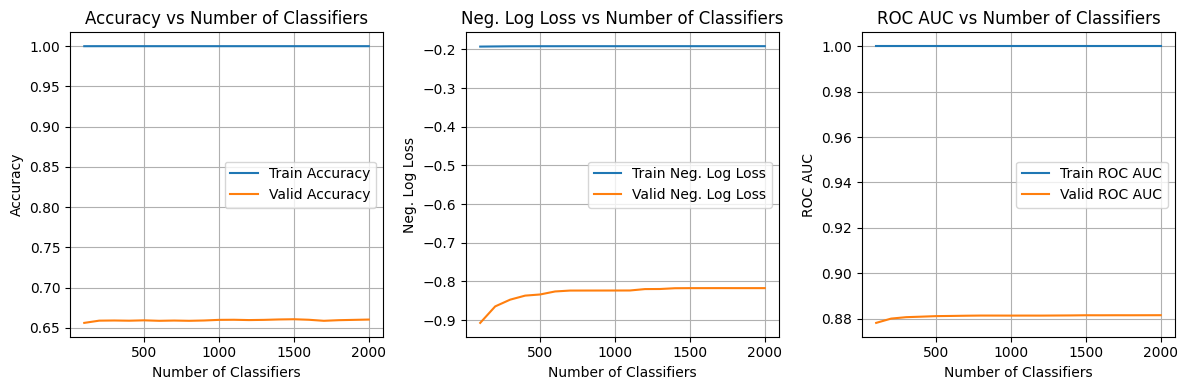

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}


In [28]:
# Evaluation plots for grid-search for random forest_0
eval_plot(rf_cv_results_df0, 'n_estimators', 'Number of Classifiers')
print(rf_gsearch0.best_params_)

In [29]:
# Grid-search for random forest_1
rf_gsearch1 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [None],
                'max_leaf_nodes': [None],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 
                                9, 10, 11, 12, 13, 14, 
                                15, 16, 17, 18, 19, 20],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

rf_gsearch1.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df1 = cv_results(rf_gsearch1)
rf_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
17,19,None,None,None,1,2,800,1,0.997674,0.658503,7,-0.214685,-0.817975,2,0.999992,0.881235,0.339171,0.603290,0.118757
15,17,None,None,None,1,2,800,2,0.989516,0.658439,4,-0.246318,-0.815345,4,0.999803,0.881037,0.331077,0.569027,0.118765
16,18,None,None,None,1,2,800,3,0.994944,0.658374,1,-0.227670,-0.812863,3,0.999952,0.881156,0.336570,0.585192,0.118796
18,20,None,None,None,1,2,800,4,0.999079,0.658115,5,-0.205989,-0.817241,1,0.999999,0.881323,0.340964,0.611252,0.118676
14,16,None,None,None,1,2,800,5,0.980777,0.657211,2,-0.272216,-0.814335,5,0.999351,0.880781,0.323566,0.542119,0.118570
13,15,None,None,None,1,2,800,6,0.965931,0.656759,3,-0.306976,-0.814613,6,0.998169,0.880315,0.309173,0.507637,0.117854
12,14,None,None,None,1,2,800,7,0.942799,0.654885,6,-0.352051,-0.817543,7,0.995452,0.879661,0.287914,0.465492,0.115790
11,13,None,None,None,1,2,800,8,0.912655,0.653011,8,-0.408013,-0.820359,8,0.990027,0.878525,0.259644,0.412346,0.111502
10,12,None,None,None,1,2,800,9,0.876341,0.649328,9,-0.474166,-0.827301,9,0.980575,0.876711,0.227013,0.353136,0.103864
9,11,None,None,None,1,2,800,10,0.833209,0.647971,10,-0.548486,-0.836523,10,0.966036,0.874155,0.185239,0.288037,0.091881


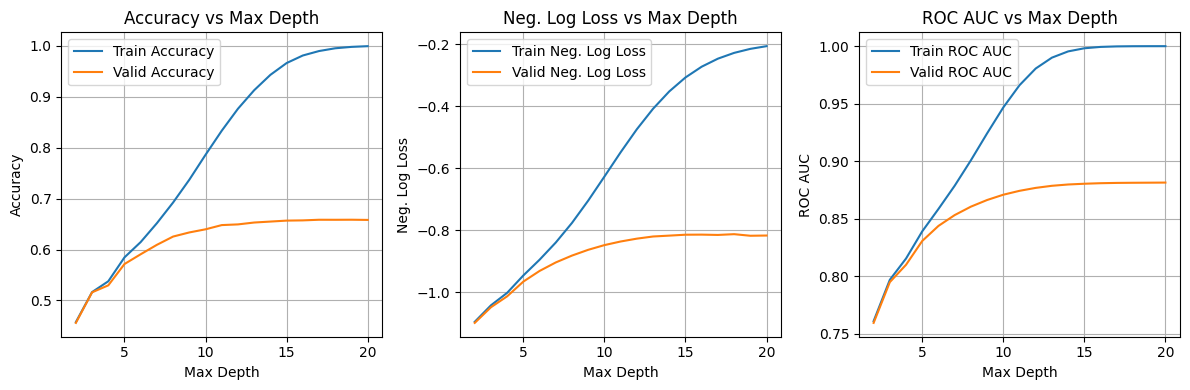

{'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [30]:
# Evaluation plots for grid-search for random forest_1
eval_plot(rf_cv_results_df1, 'max_depth', 'Max Depth')
print(rf_gsearch1.best_params_)

In [31]:
# Grid-search for random forest_2
rf_gsearch2 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [None],
                'max_leaf_nodes': list(range(10, 101, 10)),
                'max_depth': [7],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch2.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df2 = cv_results(rf_gsearch2)
rf_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
9,7,None,100,None,1,2,800,1,0.646840,0.608038,1,-0.847799,-0.905174,1,0.875616,0.852714,0.038802,0.057375,0.022902
8,7,None,90,None,1,2,800,2,0.643803,0.607715,2,-0.853784,-0.906428,2,0.873427,0.852339,0.036088,0.052644,0.021088
7,7,None,80,None,1,2,800,3,0.639684,0.607134,3,-0.860957,-0.908325,3,0.870818,0.851762,0.032550,0.047368,0.019056
6,7,None,70,None,1,2,800,4,0.634660,0.606035,4,-0.869528,-0.911288,4,0.867753,0.850804,0.028625,0.041761,0.016948
5,7,None,60,None,1,2,800,5,0.629717,0.604097,5,-0.879750,-0.915750,5,0.864053,0.849339,0.025620,0.036000,0.014714
4,7,None,50,None,1,2,800,6,0.621608,0.601060,6,-0.892209,-0.922143,6,0.859480,0.847222,0.020548,0.029934,0.012259
3,7,None,40,None,1,2,800,7,0.612739,0.597118,7,-0.908046,-0.931689,7,0.853772,0.844094,0.015621,0.023643,0.009678
2,7,None,30,None,1,2,800,8,0.602853,0.590656,8,-0.928538,-0.945819,8,0.846503,0.839464,0.012196,0.017281,0.007039
1,7,None,20,None,1,2,800,9,0.586828,0.577733,9,-0.955928,-0.968072,9,0.836462,0.831391,0.009095,0.012144,0.005071
0,7,None,10,None,1,2,800,10,0.544052,0.540062,10,-1.008881,-1.015470,10,0.814611,0.811902,0.003990,0.006589,0.002709


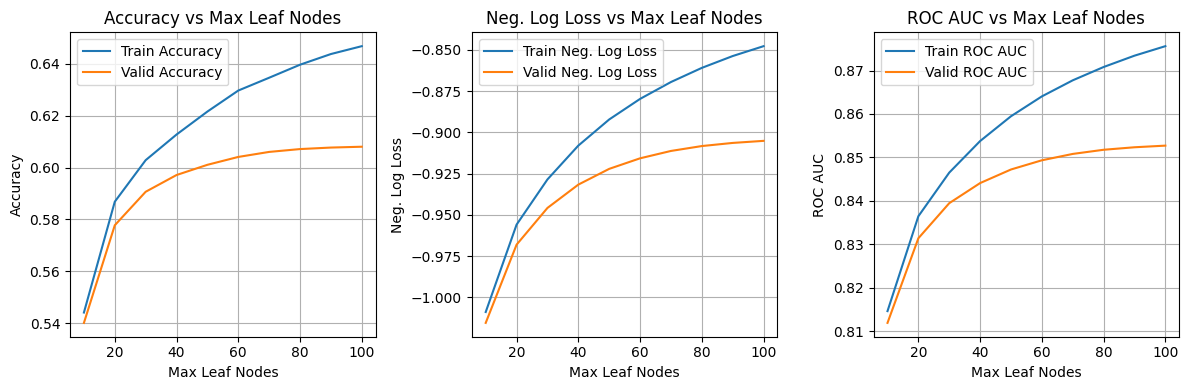

{'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 100, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [32]:
# Evaluation plots for grid-search for random forest_2
eval_plot(rf_cv_results_df2, 'max_leaf_nodes', 'Max Leaf Nodes')
print(rf_gsearch2.best_params_)

In [33]:
# Grid-search for random forest_3
rf_gsearch3 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.05, 0.1, 0.15, 0.2, 0.25, 
                                0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 
                                0.8, 0.85, 0.9, 0.95, 1.0],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch3.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df3 = cv_results(rf_gsearch3)
rf_cv_results_df3.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
8,7,0.60,30,None,1,2,800,1,0.611527,0.598345,8,-0.935448,-0.953023,6,0.849171,0.840452,0.013182,0.017575,0.008719
7,7,0.50,30,None,1,2,800,2,0.610300,0.597117,9,-0.944371,-0.961272,8,0.849000,0.839963,0.013182,0.016901,0.009037
9,7,0.70,30,None,1,2,800,3,0.610058,0.596019,7,-0.929301,-0.946790,3,0.849252,0.841137,0.014038,0.017489,0.008116
10,7,0.75,30,None,1,2,800,4,0.608991,0.594662,5,-0.926651,-0.944159,1,0.849238,0.841380,0.014329,0.017508,0.007859
11,7,0.80,30,None,1,2,800,5,0.607990,0.594016,3,-0.925425,-0.943033,2,0.848978,0.841270,0.013973,0.017608,0.007708
12,7,0.85,30,None,1,2,800,6,0.606487,0.593370,2,-0.925320,-0.943010,4,0.848769,0.841089,0.013117,0.017689,0.007680
13,7,0.90,30,None,1,2,800,7,0.605744,0.592207,1,-0.925257,-0.942781,5,0.848239,0.840850,0.013537,0.017524,0.007389
14,7,0.95,30,None,1,2,800,8,0.603935,0.590850,4,-0.926211,-0.943649,7,0.847634,0.840385,0.013085,0.017439,0.007249
6,7,0.40,30,None,1,2,800,9,0.605793,0.590785,10,-0.965563,-0.982023,10,0.847227,0.837460,0.015008,0.016460,0.009767
15,7,1.00,30,None,1,2,800,10,0.602853,0.590656,6,-0.928538,-0.945819,9,0.846503,0.839464,0.012196,0.017281,0.007039


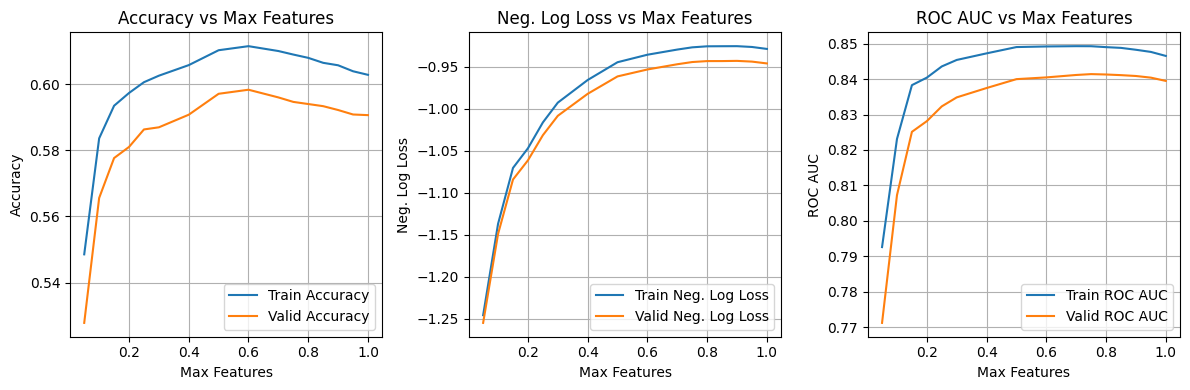

{'max_depth': 7, 'max_features': 0.6, 'max_leaf_nodes': 30, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [34]:
# Evaluation plots for grid-search for random forest_3
eval_plot(rf_cv_results_df3, 'max_features', 'Max Features')
print(rf_gsearch3.best_params_)

In [35]:
# Grid-search for random forest_4
rf_gsearch4 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.85],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch4.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df4 = cv_results(rf_gsearch4)
rf_cv_results_df4.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
5,7,0.85,30,0.30,1,2,800,1,0.613902,0.599315,2,-0.921435,-0.939653,4,0.851827,0.843441,0.014587,0.018219,0.008386
6,7,0.85,30,0.40,1,2,800,2,0.612351,0.599315,4,-0.921964,-0.939957,6,0.851137,0.842989,0.013037,0.017993,0.008148
3,7,0.85,30,0.20,1,2,800,3,0.614839,0.599185,1,-0.921217,-0.939652,1,0.852644,0.843891,0.015654,0.018435,0.008752
1,7,0.85,30,0.10,1,2,800,4,0.615954,0.599121,10,-0.923885,-0.942398,5,0.852524,0.843304,0.016833,0.018513,0.009220
2,7,0.85,30,0.15,1,2,800,5,0.615437,0.598216,6,-0.922070,-0.940615,2,0.852779,0.843770,0.017221,0.018545,0.009009
7,7,0.85,30,0.50,1,2,800,6,0.611366,0.597635,5,-0.922669,-0.940482,7,0.850561,0.842599,0.013731,0.017812,0.007962
4,7,0.85,30,0.25,1,2,800,7,0.614322,0.596989,3,-0.921337,-0.939716,3,0.852146,0.843532,0.017334,0.018379,0.008614
8,7,0.85,30,0.60,1,2,800,8,0.609621,0.596601,7,-0.923286,-0.941113,8,0.850087,0.842226,0.013020,0.017827,0.007861
9,7,0.85,30,0.70,1,2,800,9,0.608620,0.594986,8,-0.923892,-0.941653,9,0.849730,0.841931,0.013634,0.017761,0.007799
10,7,0.85,30,0.80,1,2,800,10,0.608297,0.594210,9,-0.924490,-0.942179,10,0.849335,0.841614,0.014086,0.017689,0.007721


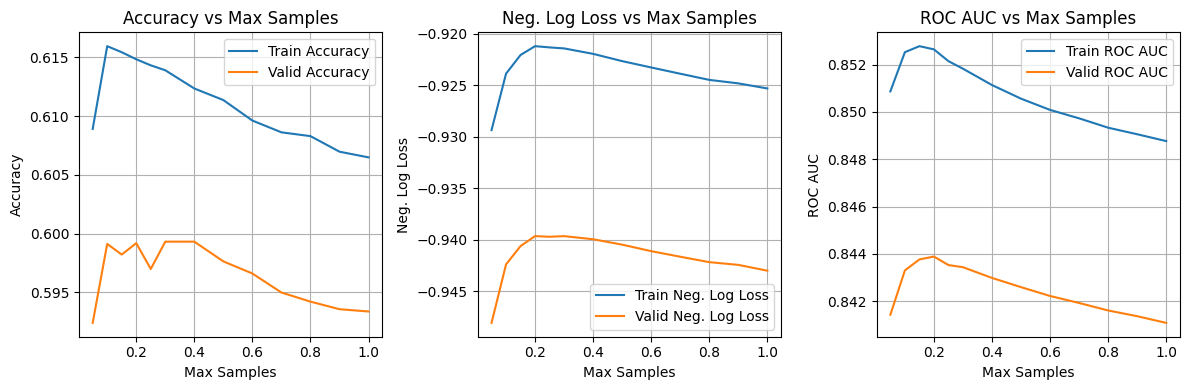

{'max_depth': 7, 'max_features': 0.85, 'max_leaf_nodes': 30, 'max_samples': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [36]:
# Evaluation plots for grid-search for random forest_4
eval_plot(rf_cv_results_df4, 'max_samples', 'Max Samples')
print(rf_gsearch4.best_params_)

In [37]:
# Grid-search for random forest_5
rf_gsearch5 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.85],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [0.2],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch5.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df5 = cv_results(rf_gsearch5)
rf_cv_results_df5.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,7,0.85,30,0.2,1,2,800,1,0.614839,0.599185,1,-0.921217,-0.939652,1,0.852644,0.843891,0.015654,0.018435,0.008752


In [38]:
# Final model for random forest 
print(rf_gsearch5.best_params_)

rf_final = rf_gsearch5.best_estimator_
rf_final.fit(X_res_ohe_scaled, y_res)

{'max_depth': 7, 'max_features': 0.85, 'max_leaf_nodes': 30, 'max_samples': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


RandomForestClassifier(max_depth=7, max_features=0.85, max_leaf_nodes=30,
                       max_samples=0.2, n_estimators=800, random_state=57)

In [39]:
# Save the model
with open('./temp/01_random_forest.pkl', 'wb') as f:
  pickle.dump(rf_final, f)

In [40]:
# Load the model
with open('./temp/01_random_forest.pkl', 'rb') as f:
  rf_final = pickle.load(f)

In [41]:
# Evaluation metrics for random forest (1)
rf_train_pred, rf_test_pred = report_for_model1(rf_final, 
                                                X_res_ohe_scaled, y_res, 
                                                X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      3869
           1       0.53      0.52      0.52      3869
           2       0.67      0.52      0.59      3869
           3       0.62      0.69      0.65      3869

    accuracy                           0.61     15476
   macro avg       0.61      0.61      0.61     15476
weighted avg       0.61      0.61      0.61     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      2266
           1       0.35      0.47      0.40       867
           2       0.69      0.48      0.57       967
           3       0.27      0.57      0.37       306

    accuracy                           0.60      4406
   macro avg       0.53      0.56      0.52      4406
weighted avg       0.66      0.60      0.62      4406



In [42]:
# Evaluation metrics for random forest (2)
report_for_model2(rf_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(rf_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.64144  0.72499   0.68066   3869.00000
1               0.52982  0.51667   0.52316   3869.00000
2               0.66744  0.52081   0.58508   3869.00000
3               0.61610  0.68648   0.64939   3869.00000
accuracy        0.61224  0.61224   0.61224      0.61224
macro avg       0.61370  0.61224   0.60957  15476.00000
weighted avg    0.61370  0.61224   0.60957  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.82636  0.70565   0.76125  2266.00000
1               0.35172  0.47059   0.40257   867.00000
2               0.68630  0.48190   0.56622   967.00000
3               0.27373  0.56536   0.36887   306.00000
accuracy        0.60054  0.60054   0.60054     0.60054
macro avg       0.53453  0.55587   0.52473  4406.00000
weighted avg    0.66384  0.60054   0.62061  4406.00000

--- Area Under t

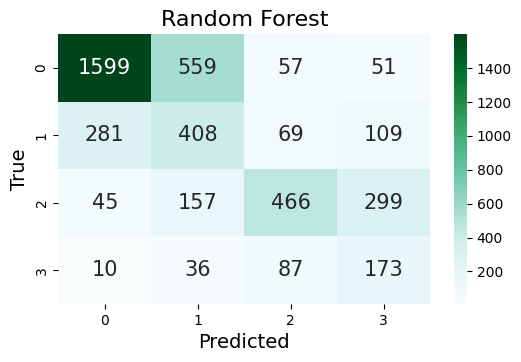

In [43]:
# Confusion matrix for random forest (testing set)
cm = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Random Forest', fontsize=16)
plt.show()

##### 05_2 XGBoost

In [44]:
# Setting for xgboost
d_train = xgb.DMatrix(data = X_res_ohe_scaled, label = y_res)

params = {'max_depth': hp.quniform("max_depth", 2, 20, 1),
          'gamma': hp.uniform ('gamma', 15, 30),
          'reg_lambda': hp.uniform('reg_lambda', 0, 1),
          'subsample': hp.uniform('subsample', 0.1, 1),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
          'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
          'n_estimators': 2000,
          'seed': seed
}

def xgb_goal(params):
  model = XGBClassifier(
    objective = 'multi:softprob',
    num_class = 4,
    eval_metric = ['merror', 'mlogloss', 'auc'],
    n_estimators = int(params['n_estimators']),
    learning_rate = 0.01,
    max_depth = int(params['max_depth']),
    min_child_weight = int(params['min_child_weight']),
    gamma = params['gamma'],
    subsample = params['subsample'],
    colsample_bytree = params['colsample_bytree'],
    early_stopping_rounds = 50,
    reg_alpha = 0,
    reg_lambda = params['reg_lambda'],
    random_state = seed
  )

  xgb_cv_results_df = xgb.cv(
    params = model.get_xgb_params(),
    dtrain = d_train,
    nfold = 5,
    num_boost_round = model.get_params()['n_estimators'],
    early_stopping_rounds = model.get_params()['early_stopping_rounds'],
    seed = seed
  )

  best_score = min(xgb_cv_results_df['test-merror-mean'])
  best_round = len(xgb_cv_results_df)

  return {'loss': best_score, 'best_round': best_round, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = xgb_goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate = np.random.default_rng(seed))

print("Best Hyperparameters:", best_hyperparams)
print(f"Best round (with early stopping applied): {trials.best_trial['result']['best_round']}")

100%|██████████| 100/100 [1:04:49<00:00, 38.90s/trial, best loss: 0.3739340354744044]
Best Hyperparameters: {'colsample_bytree': np.float64(0.9090801830657607), 'gamma': np.float64(16.46024513002559), 'max_depth': np.float64(18.0), 'min_child_weight': np.float64(14.0), 'reg_lambda': np.float64(0.47502422515024234), 'subsample': np.float64(0.9514752546095017)}
Best round (with early stopping applied): 640


In [45]:
# xgboost_1
xgb_clf1 = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=20,
    min_child_weight=6,
    gamma=15,
    subsample=0.99,
    colsample_bytree=0.79,
    reg_alpha=0,
    reg_lambda=0.05,
    early_stopping_rounds=50,
    random_state=seed
    )

model = xgb_clf1

xgb_cv_results_df1 = xgb.cv(
    model.get_xgb_params(),
    d_train,
    nfold=5,
    num_boost_round=model.get_params()['n_estimators'],
    early_stopping_rounds=model.get_params()['early_stopping_rounds'],
    seed=seed
)

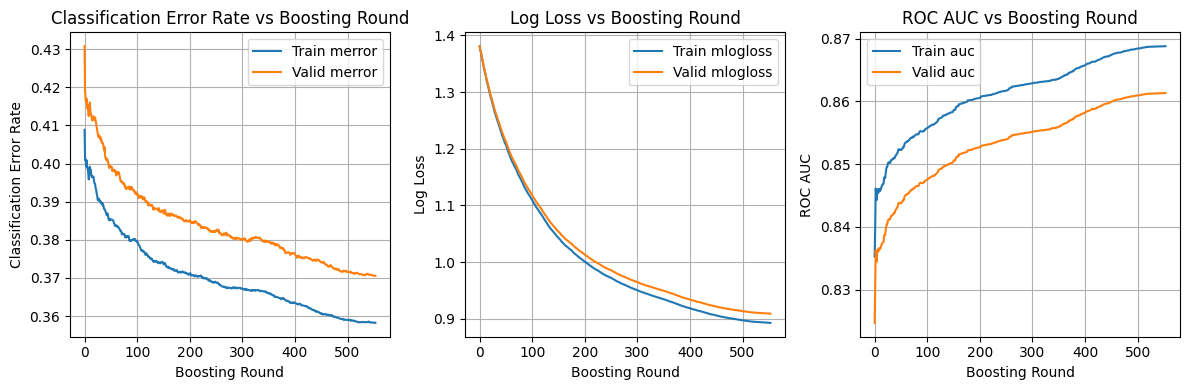

In [46]:
# Plots for xgboost_1
xgb_eval_plots(xgb_cv_results_df1)

In [47]:
# Evaluation metrics for xgboost_1
dftmp = xgb_cv_results_df1
dftmp.loc[[dftmp['test-merror-mean'].idxmin(), 
           dftmp['test-mlogloss-mean'].idxmin(), 
           dftmp['test-auc-mean'].idxmax()],
 ['train-merror-mean', 'test-merror-mean', 
  'train-mlogloss-mean', 'test-mlogloss-mean', 
  'train-auc-mean', 'test-auc-mean']]

,train-merror-mean,test-merror-mean,train-mlogloss-mean,test-mlogloss-mean,train-auc-mean,test-auc-mean
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134


In [48]:
# Determine boosting round
tmp = 550
dftmp = xgb_cv_results_df1
print(dftmp.loc[tmp,['train-merror-mean', 'test-merror-mean', 
                     'train-mlogloss-mean', 'test-mlogloss-mean', 
                     'train-auc-mean', 'test-auc-mean']])
print(1 - xgb_cv_results_df1.loc[tmp, ['train-merror-mean', 'test-merror-mean']])

train-merror-mean      0.358248
test-merror-mean       0.370574
train-mlogloss-mean    0.893012
test-mlogloss-mean     0.909320
train-auc-mean         0.868793
test-auc-mean          0.861329
Name: 550, dtype: float64
train-merror-mean    0.641752
test-merror-mean     0.629426
Name: 550, dtype: float64


In [49]:
# Xgboost final model
xgb_final = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=550,
    learning_rate=0.01,
    max_depth=20,
    min_child_weight=6,
    gamma=15,
    subsample=0.99,
    colsample_bytree=0.79,
    reg_alpha=0,
    reg_lambda=0.05,
    # early_stopping_rounds=50,
    random_state=seed
    )

print(xgb_final.get_xgb_params())

xgb_final.fit(X_res_ohe_scaled, y_res)

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.79, 'device': None, 'eval_metric': ['merror', 'mlogloss', 'auc'], 'gamma': 15, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 20, 'max_leaves': None, 'min_child_weight': 6, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 57, 'reg_alpha': 0, 'reg_lambda': 0.05, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.99, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.79, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=['merror', 'mlogloss', 'auc'], feature_types=None,
              feature_weights=None, gamma=15, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=550,
              n_jobs=None, num_class=4, ...)

In [50]:
# Save the model
with open('./temp/02_xgboost.pkl', 'wb') as f:
  pickle.dump(xgb_final, f)

In [51]:
# Load the model
with open('./temp/02_xgboost.pkl', 'rb') as f:
  xgb_final = pickle.load(f)

In [52]:
# Evaluation metrics for xgboost (1)
xgb_train_pred, xgb_test_pred = report_for_model1(xgb_final, 
                                                  X_res_ohe_scaled, y_res, 
                                                  X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.65      0.72      0.69      3869
           1       0.54      0.52      0.53      3869
           2       0.67      0.66      0.66      3869
           3       0.74      0.69      0.71      3869

    accuracy                           0.65     15476
   macro avg       0.65      0.65      0.65     15476
weighted avg       0.65      0.65      0.65     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      2266
           1       0.37      0.51      0.43       867
           2       0.66      0.62      0.64       967
           3       0.31      0.39      0.34       306

    accuracy                           0.63      4406
   macro avg       0.54      0.55      0.54      4406
weighted avg       0.67      0.63      0.64      4406



In [53]:
# Evaluation metrics for xgboost (2)
report_for_model2(xgb_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(xgb_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.65374  0.72318   0.68671   3869.00000
1               0.53526  0.52184   0.52846   3869.00000
2               0.67088  0.65909   0.66493   3869.00000
3               0.73668  0.68984   0.71249   3869.00000
accuracy        0.64849  0.64849   0.64849      0.64849
macro avg       0.64914  0.64849   0.64815  15476.00000
weighted avg    0.64914  0.64849   0.64815  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.83039  0.70653   0.76347  2266.00000
1               0.36776  0.50519   0.42566   867.00000
2               0.66482  0.61944   0.64133   967.00000
3               0.30570  0.38562   0.34104   306.00000
accuracy        0.62551  0.62551   0.62551     0.62551
macro avg       0.54217  0.55420   0.54287  4406.00000
weighted avg    0.66658  0.62551   0.64085  4406.00000

--- Area Under t

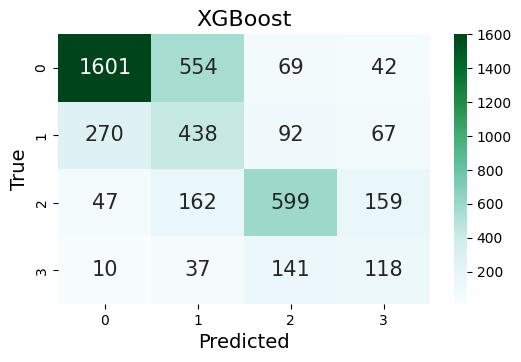

In [54]:
# Confusion matrix for xgboost (testing set)
cm = confusion_matrix(y_test, xgb_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('XGBoost', fontsize=16)
plt.show()

##### 05_3 Logistic regression

In [55]:
mlogit = LogisticRegression(max_iter=1000, random_state=seed)

In [56]:
# Grid-search for logistic regression_0
mlogit_gsearch0 = GridSearchCV(
    param_grid={'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                'penalty': [None, 'l2'],
                'C': [1]},
                estimator=mlogit,
                cv=cv,
                scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
                refit='accuracy',
                return_train_score=True
) 

mlogit_gsearch0.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df0 = cv_results(mlogit_gsearch0)
mlogit_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
7,1,l2,saga,1,0.601027,0.595696,3,-0.926468,-0.934986,7,0.842974,0.839329,0.005331,0.008517,0.003645
6,1,l2,sag,2,0.601027,0.595567,2,-0.926468,-0.934982,6,0.842974,0.839331,0.005461,0.008514,0.003643
5,1,l2,newton-cg,3,0.601140,0.595502,4,-0.926468,-0.934994,8,0.842974,0.839324,0.005638,0.008525,0.003650
4,1,l2,lbfgs,4,0.601221,0.595244,1,-0.926476,-0.934970,5,0.842972,0.839340,0.005978,0.008493,0.003633
2,1,None,sag,5,0.601140,0.595115,7,-0.926413,-0.935042,3,0.843055,0.839415,0.006026,0.008629,0.003641
0,1,None,lbfgs,6,0.601383,0.595115,5,-0.926419,-0.935035,1,0.843055,0.839421,0.006268,0.008616,0.003634
3,1,None,saga,7,0.601157,0.595050,6,-0.926413,-0.935042,2,0.843055,0.839416,0.006107,0.008629,0.003640
1,1,None,newton-cg,8,0.601124,0.595050,8,-0.926413,-0.935049,4,0.843055,0.839412,0.006074,0.008636,0.003643


In [57]:
# Grid-search for logistic regression_1
mlogit_gsearch1 = GridSearchCV(
    param_grid={'solver': ['lbfgs'],
                'penalty': ['l2'],
                'C': [0.01, 0.1, 1, 10]},
    estimator=mlogit,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True
)

mlogit_gsearch1.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df1 = cv_results(mlogit_gsearch1)
mlogit_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
3,10.00,l2,lbfgs,1,0.601334,0.595308,2,-0.926420,-0.935029,1,0.843046,0.839415,0.006026,0.008610,0.003631
2,1.00,l2,lbfgs,2,0.601221,0.595244,1,-0.926476,-0.934970,2,0.842972,0.839340,0.005978,0.008493,0.003633
1,0.10,l2,lbfgs,3,0.598378,0.593822,3,-0.929809,-0.937583,3,0.842055,0.838367,0.004556,0.007774,0.003688
0,0.01,l2,lbfgs,4,0.576893,0.572757,4,-0.978595,-0.984130,4,0.832135,0.828457,0.004136,0.005535,0.003678


In [58]:
# Grid-search for logistic regression_2
mlogit_gsearch2 = GridSearchCV(
    param_grid={'solver': ['lbfgs'],
                'penalty': ['l2'],
                'C': [10]},
    estimator=mlogit,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True
)

mlogit_gsearch2.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df2 = cv_results(mlogit_gsearch2)
mlogit_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,10,l2,lbfgs,1,0.601334,0.595308,1,-0.92642,-0.935029,1,0.843046,0.839415,0.006026,0.00861,0.003631


In [59]:
# Logistic regression final model
print(mlogit_gsearch2.best_params_)

mlogit_final = mlogit_gsearch2.best_estimator_
mlogit_final.fit(X_res_ohe_scaled, y_res)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


LogisticRegression(C=10, max_iter=1000, random_state=57)

In [60]:
# Save the model
with open('./temp/03_logistic_regression.pkl', 'wb') as f:
  pickle.dump(mlogit_final, f)

In [61]:
# Load the model
with open('./temp//03_logistic_regression.pkl', 'rb') as f:
  mlogit_final = pickle.load(f)

In [62]:
# Evaluation metrics for logistric regression (1)
mlogit_train_pred, mlogit_test_pred = report_for_model1(mlogit_final, 
                                                        X_res_ohe_scaled, y_res, 
                                                        X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3869
           1       0.50      0.53      0.51      3869
           2       0.63      0.53      0.58      3869
           3       0.60      0.64      0.62      3869

    accuracy                           0.60     15476
   macro avg       0.60      0.60      0.60     15476
weighted avg       0.60      0.60      0.60     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2266
           1       0.35      0.48      0.41       867
           2       0.66      0.51      0.58       967
           3       0.24      0.47      0.31       306

    accuracy                           0.60      4406
   macro avg       0.52      0.54      0.52      4406
weighted avg       0.66      0.60      0.62      4406



In [63]:
# Evaluation metrics for logistric regression (2)
report_for_model2(mlogit_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(mlogit_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.67760  0.70457   0.69083   3869.00000
1               0.50184  0.52856   0.51485   3869.00000
2               0.62929  0.53089   0.57591   3869.00000
3               0.60209  0.64022   0.62057   3869.00000
accuracy        0.60106  0.60106   0.60106      0.60106
macro avg       0.60271  0.60106   0.60054  15476.00000
weighted avg    0.60271  0.60106   0.60054  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.84148  0.69109   0.75890  2266.00000
1               0.35309  0.48097   0.40723   867.00000
2               0.66489  0.51499   0.58042   967.00000
3               0.23577  0.47386   0.31488   306.00000
accuracy        0.59601  0.59601   0.59601     0.59601
macro avg       0.52381  0.54023   0.51536  4406.00000
weighted avg    0.66455  0.59601   0.61969  4406.00000

--- Area Under t

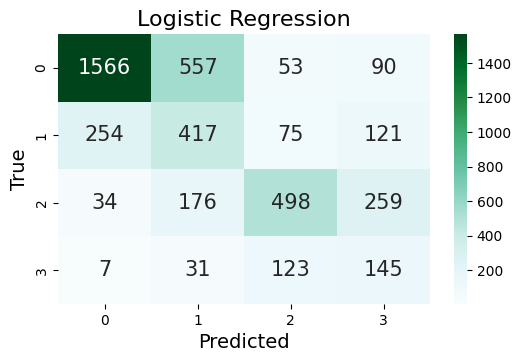

In [64]:
# Confusion matrix for logistic regression (testing set)
cm = confusion_matrix(y_test, mlogit_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Logistic Regression', fontsize=16)
plt.show()

##### 05_4 Support Vector Machine

In [65]:
svc = SVC(probability=True, random_state=seed)

In [66]:
# Undersampling for tuning
rus_2 = RandomUnderSampler(
    sampling_strategy={0: 100, 1: 100, 2: 100, 3: 100}, 
    random_state=seed
)

X_res_ohe_scaled_rus_2, y_res_rus_2 = rus_2.fit_resample(X_res_ohe_scaled, y_res)

In [67]:
# Grid-search for SVM_0
svc_gsearch0 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'C': [1],
                'gamma': ['scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch0.fit(X_res_ohe_scaled_rus_2, y_res_rus_2)

svc_cv_results_df0 = cv_results(svc_gsearch0)
svc_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,1,0,3,scale,linear,1,0.680000,0.5075,1,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
4,1,0,3,auto,linear,1,0.680000,0.5075,1,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
5,1,0,3,auto,rbf,3,0.597500,0.4750,5,-0.941765,-1.134604,5,0.859557,0.749250,0.122500,0.192839,0.110307
1,1,0,3,scale,rbf,3,0.781875,0.4750,6,-0.752991,-1.159118,6,0.950844,0.732958,0.306875,0.406127,0.217885
7,1,0,3,auto,sigmoid,5,0.516875,0.4525,4,-1.024379,-1.126561,4,0.817490,0.757417,0.064375,0.102182,0.060073
3,1,0,3,scale,sigmoid,6,0.495625,0.4325,3,-1.078915,-1.109381,3,0.786221,0.767667,0.063125,0.030466,0.018555
2,1,0,3,scale,poly,7,0.813750,0.4300,7,-0.889012,-1.219967,7,0.959990,0.704208,0.383750,0.330955,0.255781
6,1,0,3,auto,poly,8,0.312500,0.2875,8,-1.334592,-1.358067,8,0.688943,0.612083,0.025000,0.023475,0.076859


In [68]:
# Grid-search for SVM_1
svc_gsearch1 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf'],
                'C': [0.01, 0.1, 1, 10, 100, 500, 1000],
                'gamma': [0.001, 0.0015, 0.002, 'scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch1.fit(X_res_ohe_scaled_rus_2, y_res_rus_2,)

svc_cv_results_df1 = cv_results(svc_gsearch1)
svc_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
24,1.00,0,3,0.002,linear,1,0.68000,0.5075,4,-0.942527,-1.096051,1,0.876081,0.778125,0.17250,0.153524,0.097956
26,1.00,0,3,scale,linear,1,0.68000,0.5075,4,-0.942527,-1.096051,1,0.876081,0.778125,0.17250,0.153524,0.097956
20,1.00,0,3,0.001,linear,1,0.68000,0.5075,4,-0.942527,-1.096051,1,0.876081,0.778125,0.17250,0.153524,0.097956
28,1.00,0,3,auto,linear,1,0.68000,0.5075,4,-0.942527,-1.096051,1,0.876081,0.778125,0.17250,0.153524,0.097956
22,1.00,0,3,0.0015,linear,1,0.68000,0.5075,4,-0.942527,-1.096051,1,0.876081,0.778125,0.17250,0.153524,0.097956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.10,0,3,0.001,rbf,65,0.38625,0.3425,66,-1.387383,-1.387190,66,0.382852,0.395583,0.04375,-0.000193,-0.012732
3,0.01,0,3,0.0015,rbf,65,0.38500,0.3425,63,-1.386294,-1.386294,63,0.500000,0.500000,0.04250,0.000000,0.000000
1,0.01,0,3,0.001,rbf,65,0.38625,0.3425,63,-1.386294,-1.386294,63,0.500000,0.500000,0.04375,0.000000,0.000000
23,1.00,0,3,0.0015,rbf,65,0.38500,0.3425,60,-1.316699,-1.327965,52,0.755456,0.736958,0.04250,0.011266,0.018497


In [69]:
# Grid-search for SVM_2
svc_gsearch2 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf'],
                'C': [0.1, 1, 100],
                'gamma': [0.001, 0.005, 0.01, 'scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch2.fit(X_res_ohe_scaled_rus_2, y_res_rus_2)

svc_cv_results_df2 = cv_results(svc_gsearch2)
svc_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
12,1.0,0,3,0.005,linear,1,0.680000,0.5075,2,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
14,1.0,0,3,0.01,linear,1,0.680000,0.5075,2,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
10,1.0,0,3,0.001,linear,1,0.680000,0.5075,2,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
16,1.0,0,3,scale,linear,1,0.680000,0.5075,2,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
18,1.0,0,3,auto,linear,1,0.680000,0.5075,2,-0.942527,-1.096051,1,0.876081,0.778125,0.172500,0.153524,0.097956
2,0.1,0,3,0.005,linear,6,0.619375,0.4925,7,-0.958049,-1.101977,7,0.852503,0.770667,0.126875,0.143928,0.081836
8,0.1,0,3,auto,linear,6,0.619375,0.4925,7,-0.958049,-1.101977,7,0.852503,0.770667,0.126875,0.143928,0.081836
0,0.1,0,3,0.001,linear,6,0.619375,0.4925,7,-0.958049,-1.101977,7,0.852503,0.770667,0.126875,0.143928,0.081836
6,0.1,0,3,scale,linear,6,0.619375,0.4925,7,-0.958049,-1.101977,7,0.852503,0.770667,0.126875,0.143928,0.081836
4,0.1,0,3,0.01,linear,6,0.619375,0.4925,7,-0.958049,-1.101977,7,0.852503,0.770667,0.126875,0.143928,0.081836


In [70]:
# Grid-search for SVM_3
svc_gsearch3 = GridSearchCV(
    param_grid={'kernel': ['rbf'],
                'C': [100],
                'gamma': [0.001],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch3.fit(X_res_ohe_scaled, y_res)

svc_cv_results_df3 = cv_results(svc_gsearch3)
svc_cv_results_df3.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,100,0,3,0.001,rbf,1,0.614403,0.604549,1,-0.907291,-0.922161,1,0.8513,0.844918,0.009854,0.01487,0.006382


In [71]:
# SVM fianl model
print(svc_gsearch3.best_params_)

svc_final = svc_gsearch3.best_estimator_
svc_final.fit(X_res_ohe_scaled, y_res)

{'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf'}


SVC(C=100, coef0=0, gamma=0.001, probability=True, random_state=57)

In [72]:
# Save the model
with open('./temp/04_SVC.pkl', 'wb') as f:
  pickle.dump(svc_final, f)

In [73]:
# Load the model
with open('./temp/04_SVC.pkl', 'rb') as f:
  svc_final = pickle.load(f)

In [74]:
# Evaluation metrics for SVM (1)
svc_train_pred, svc_test_pred = report_for_model1(svc_final, 
                                                  X_res_ohe_scaled, y_res, 
                                                  X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3869
           1       0.51      0.58      0.54      3869
           2       0.66      0.53      0.58      3869
           3       0.64      0.65      0.64      3869

    accuracy                           0.61     15476
   macro avg       0.62      0.61      0.61     15476
weighted avg       0.62      0.61      0.61     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.84      0.69      0.75      2266
           1       0.35      0.51      0.42       867
           2       0.66      0.50      0.57       967
           3       0.25      0.44      0.32       306

    accuracy                           0.59      4406
   macro avg       0.52      0.54      0.51      4406
weighted avg       0.66      0.59      0.62      4406



In [75]:
# Evaluation metrics for SVM (2)
report_for_model2(svc_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(svc_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.67910  0.70121   0.68998   3869.00000
1               0.50773  0.57689   0.54011   3869.00000
2               0.65637  0.52727   0.58478   3869.00000
3               0.63540  0.65314   0.64415   3869.00000
accuracy        0.61463  0.61463   0.61463      0.61463
macro avg       0.61965  0.61463   0.61475  15476.00000
weighted avg    0.61965  0.61463   0.61475  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.83765  0.68535   0.75388  2266.00000
1               0.34933  0.51211   0.41534   867.00000
2               0.66030  0.50052   0.56941   967.00000
3               0.24818  0.44444   0.31850   306.00000
accuracy        0.59396  0.59396   0.59396     0.59396
macro avg       0.52386  0.53561   0.51428  4406.00000
weighted avg    0.66170  0.59396   0.61654  4406.00000

--- Area Under t

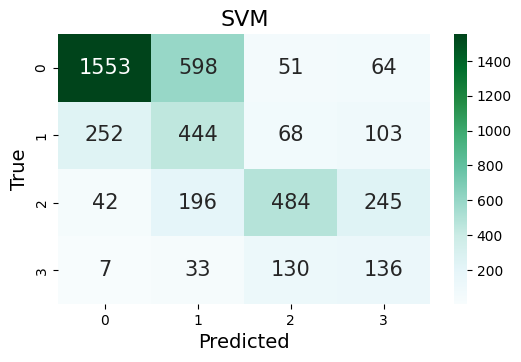

In [76]:
# Confusion matrix for SVC (testing set)
cm = confusion_matrix(y_test, svc_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('SVM', fontsize=16)
plt.show()

##### 05_5 Moderl performance comparison

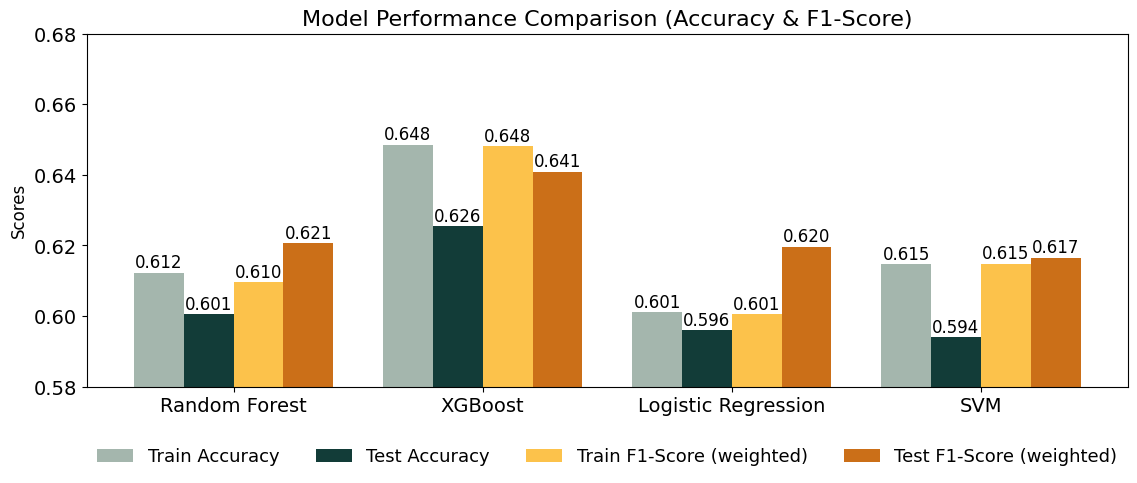

In [77]:
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM']

accuracy_train = [
    accuracy_score(y_res, rf_train_pred),
    accuracy_score(y_res, xgb_train_pred),
    accuracy_score(y_res, mlogit_train_pred),
    accuracy_score(y_res, svc_train_pred)
]

accuracy_test = [
    accuracy_score(y_test, rf_test_pred),
    accuracy_score(y_test, xgb_test_pred),
    accuracy_score(y_test, mlogit_test_pred),
    accuracy_score(y_test, svc_test_pred)
]

f1_train = [
    f1_score(y_res, rf_train_pred, average='weighted'),
    f1_score(y_res, xgb_train_pred, average='weighted'),
    f1_score(y_res, mlogit_train_pred, average='weighted'),
    f1_score(y_res, svc_train_pred, average='weighted')
]

f1_test = [
    f1_score(y_test, rf_test_pred, average='weighted'),
    f1_score(y_test, xgb_test_pred, average='weighted'),
    f1_score(y_test, mlogit_test_pred, average='weighted'),
    f1_score(y_test, svc_test_pred, average='weighted')
]

model_results = pd.DataFrame({'Model': models,
                              'Accuracy (Train)': accuracy_train,
                              'Accuracy (Test)': accuracy_test,
                              'F1-Score (Train)': f1_train,
                              'F1-Score (Test)': f1_test})

plt.figure(figsize=(12, 5))

bar_width = 0.20
index = range(len(models))
plt.bar(index, accuracy_train, bar_width, label='Train Accuracy', alpha=0.8, color='#8EA499')
plt.bar([i + bar_width for i in index], accuracy_test, bar_width, label='Test Accuracy', color='#123C38')

plt.bar([i + 2 * bar_width for i in index], f1_train, bar_width, label='Train F1-Score (weighted)', alpha=0.8, color='#FCB31E')
plt.bar([i + 3 * bar_width for i in index], f1_test, bar_width, label='Test F1-Score (weighted)', color='#CB6F18')

for i in range(len(models)):
    plt.text(i, accuracy_train[i] + 0.0003, f'{accuracy_train[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + bar_width, accuracy_test[i] + 0.0003, f'{accuracy_test[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + 2 * bar_width, f1_train[i] + 0.0003, f'{f1_train[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + 3 * bar_width, f1_test[i] + 0.0003, f'{f1_test[i]:.3f}', ha='center', va='bottom', fontsize=12)

plt.ylabel('Scores', fontsize=12)
plt.title('Model Performance Comparison (Accuracy & F1-Score)', fontsize=16)
plt.xticks([i + 1.5 * bar_width for i in index], models)
plt.ylim(0.58, 0.68)

plt.legend(loc='center', frameon=False, borderaxespad=-0.46, ncol=4, prop={'size': 13}, bbox_to_anchor=(0., -0.25, 1., .102))
plt.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('./plots/model_performance_comparison.png', bbox_inches='tight')
plt.show()

##### 05_6 Featuer importance (XGBoost)

In [78]:
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_test_ohe_scaled)

shap_values.shape

(4406, 34, 4)

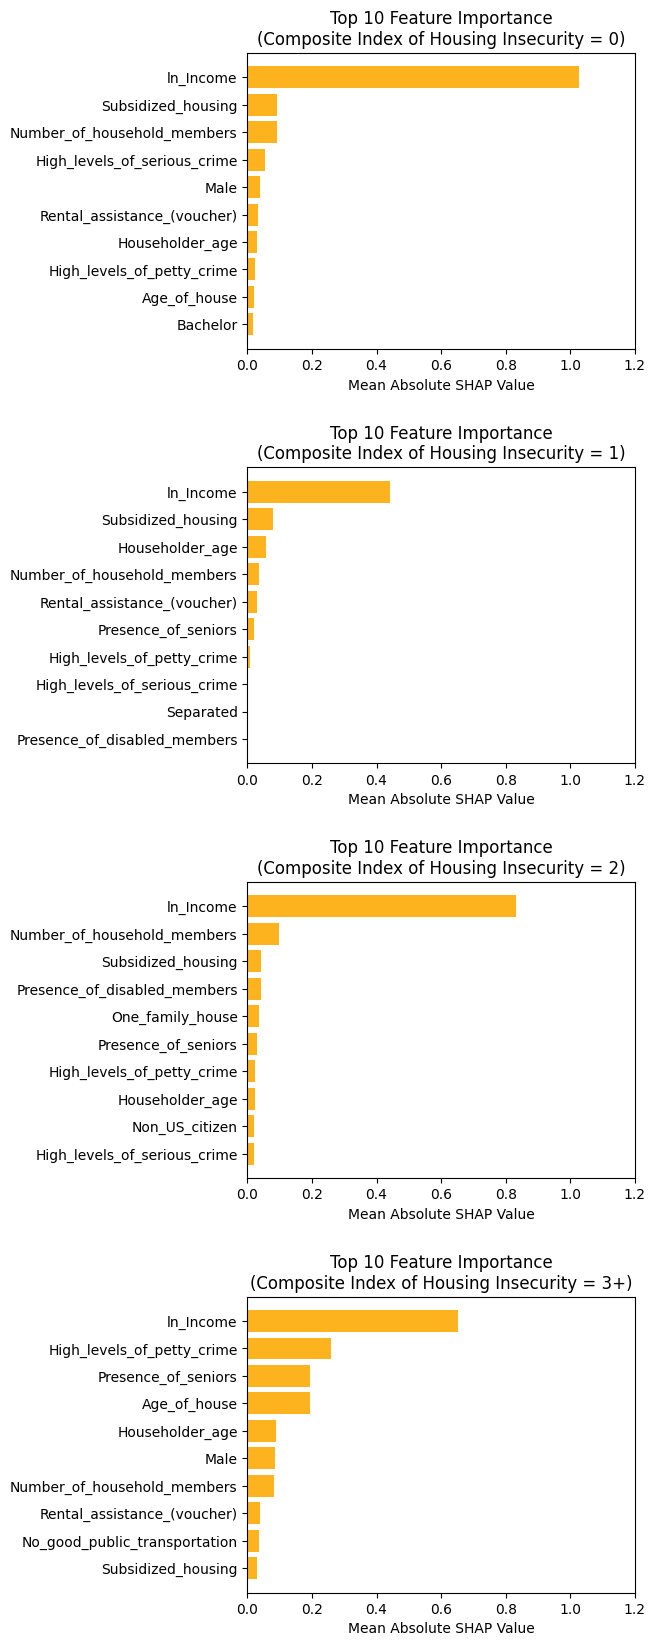

In [79]:
# SHAP feature importance plopts
feature_names = X_test_ohe_scaled.columns
top_n = 10

titles = [
    'Composite Index of Housing Insecurity = 0',
    'Composite Index of Housing Insecurity = 1',
    'Composite Index of Housing Insecurity = 2',
    'Composite Index of Housing Insecurity = 3+'
]

fig, axs = plt.subplots(4, 1, figsize=(5, 20))
axs = axs.flatten()

for i, c in enumerate([0, 1, 2, 3]):
    shap_values_class = shap_values[:, :, c]
    mean_shap_values = np.mean(np.abs(shap_values_class), axis=0)

    sorted_idx = np.argsort(mean_shap_values)[::-1]
    top_idx = sorted_idx[:top_n]
    top_mean_shap_values = mean_shap_values[top_idx]
    top_feature_names = feature_names[top_idx]

    ax = axs[i]
    ax.barh(range(top_n), top_mean_shap_values, align='center', color='#FCB31E')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_feature_names)
    ax.set_xlim((0, 1.2))
    ax.set_xlabel('Mean Absolute SHAP Value')
    ax.set_title(f'Top {top_n} Feature Importance\n({titles[i]})')
    ax.invert_yaxis()

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.savefig('./plots/feature_importance_combined.png', bbox_inches='tight')
plt.show()

In [80]:
explainer2 = shap.TreeExplainer(xgb_final, X_res_ohe_scaled)
shap_values2 = explainer2(X_test_ohe_scaled)

100%|===================| 17609/17624 [07:42<00:00]        

In [81]:
# Save explainer2
with open('./temp/explainer2.pkl', 'wb') as f:
    pickle.dump(explainer2, f)

# Save shap_values2
with open('./temp/shap_values2.pkl', 'wb') as f:
    pickle.dump(shap_values2, f)

In [82]:
# Load explainer2
with open('./temp/explainer2.pkl', 'rb') as f:
    explainer2 = pickle.load(f)

# Load shap_values2
with open('./temp/shap_values2.pkl', 'rb') as f:
    shap_values2 = pickle.load(f)

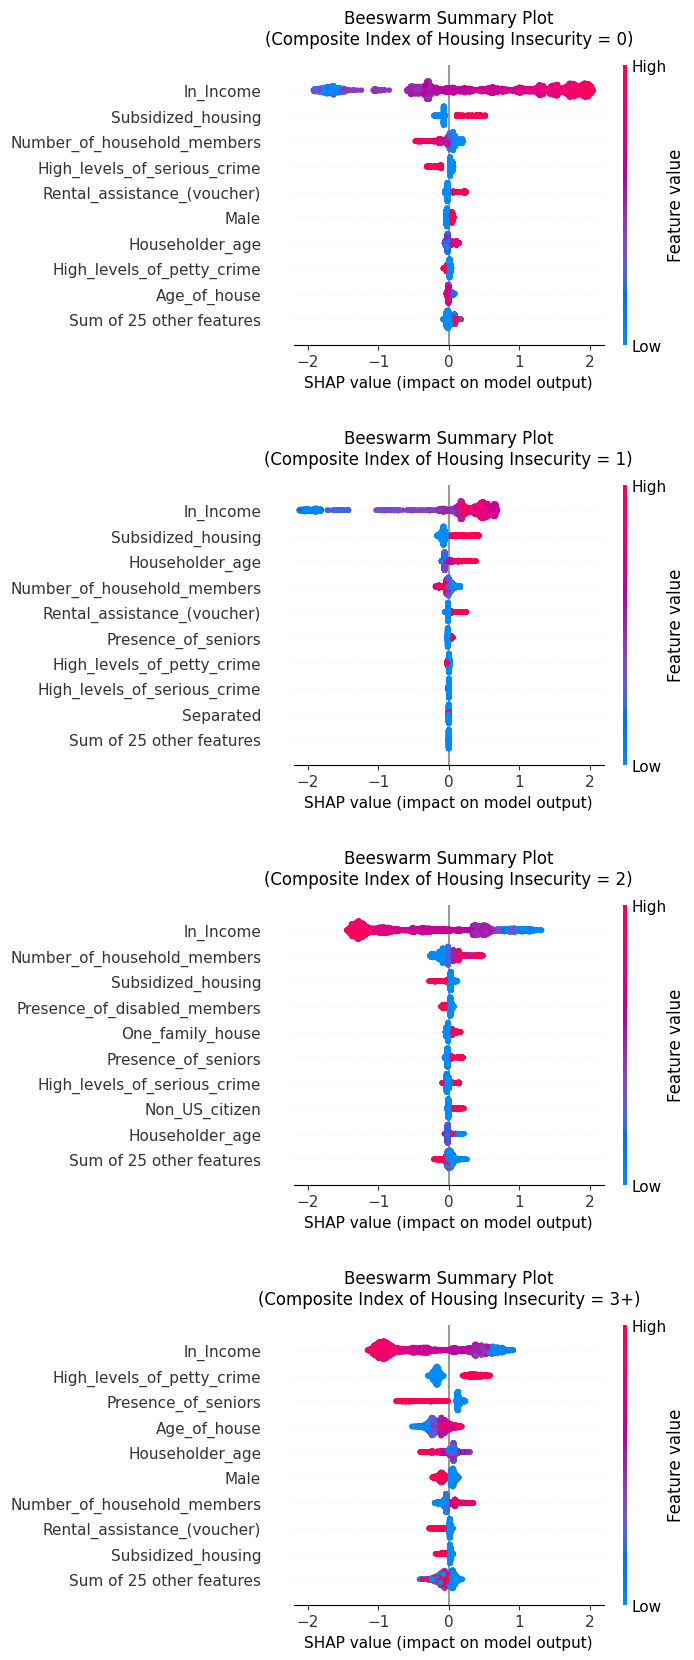

In [83]:
# SHAP beswarm summary plots
np.random.seed(seed)

fig, axs = plt.subplots(4, 1, figsize=(5, 20))  
axs = axs.flatten()

titles = [
    'Composite Index of Housing Insecurity = 0',
    'Composite Index of Housing Insecurity = 1',
    'Composite Index of Housing Insecurity = 2',
    'Composite Index of Housing Insecurity = 3+'
]

for i in range(4):
    ax = axs[i]
    
    shap.plots.beeswarm(
        shap_values2[:, :, i],
        show=False,
        plot_size=None,
        ax=ax,
        max_display=10 
    )
    ax.set_xlim([-2.2, 2.2])
    ax.set_title(f'Beeswarm Summary Plot\n({titles[i]})', fontsize=12, pad=15)

    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=11)
    ax.xaxis.label.set_fontsize(11)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('./plots/beeswarm_combined.png', bbox_inches='tight')
plt.show()

#### For reference: Models built using a dataset without under- or over-sampling

1. Random forest

In [84]:
rf2_clf = RandomForestClassifier(bootstrap=True, random_state=seed)

In [85]:
params = {
    'n_estimators': hp.quniform('n_estimators', 800, 1200, 100),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 10, 30, 5),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'random_state': seed
}

def rf2_goal(params):
    model = RandomForestClassifier(
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        max_leaf_nodes = int(params['max_leaf_nodes']),
        max_samples = params['max_samples'],
        min_samples_split = int(params['min_samples_split']),
        min_samples_leaf = int(params['min_samples_leaf']),
        max_features = params['max_features'],
        random_state = params['random_state']
    )
    
    cv_results = cross_validate(model, X_train_ohe_scaled, y_train, 
                               cv = cv, scoring = 'accuracy', 
                               return_train_score = True)

    val_acc = np.mean(cv_results['test_score'])
    train_acc = np.mean(cv_results['train_score'])

    return {'loss': -val_acc, 'status': STATUS_OK,
            'train_accuracy': train_acc, 'val_accuracy': val_acc}

trials = Trials()

best_hyperparams = fmin(fn = rf2_goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate = np.random.default_rng(seed))

print("Best Hyperparameters:", best_hyperparams)
print(f"Best Train Accuracy: {trials.best_trial['result']['train_accuracy']}")
print(f"Best Validation Accuracy: {trials.best_trial['result']['val_accuracy']}")

100%|██████████| 100/100 [2:38:24<00:00, 95.04s/trial, best loss: -0.6881569621883579]   
Best Hyperparameters: {'max_depth': np.float64(15.0), 'max_features': np.float64(0.7268194130594714), 'max_leaf_nodes': np.float64(30.0), 'max_samples': np.float64(0.5000313116015459), 'min_samples_leaf': np.float64(2.0), 'min_samples_split': np.float64(6.0), 'n_estimators': np.float64(1200.0)}
Best Train Accuracy: 0.6948953273480474
Best Validation Accuracy: 0.6881569621883579


In [86]:
rf2_gsearch1 = GridSearchCV(
    param_grid={'n_estimators': [1000],
                'max_features': [0.996],
                'max_leaf_nodes': [25],
                'max_depth': [9],
                'max_samples': [0.3524],
                'min_samples_split': [2],
                'min_samples_leaf': [2]},
    estimator=rf2_clf,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf2_gsearch1.fit(X_train_ohe_scaled, y_train)

rf2_cv_results_df1 = cv_results(rf2_gsearch1)
rf2_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,9,0.996,25,0.3524,2,2,1000,1,0.693335,0.685944,1,-0.764422,-0.77852,1,0.852408,0.845518,0.007391,0.014098,0.00689


In [87]:
print(rf2_gsearch1.best_params_)

rf2_final = rf2_gsearch1.best_estimator_
rf2_final.fit(X_train_ohe_scaled, y_train)

{'max_depth': 9, 'max_features': 0.996, 'max_leaf_nodes': 25, 'max_samples': 0.3524, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}


RandomForestClassifier(max_depth=9, max_features=0.996, max_leaf_nodes=25,
                       max_samples=0.3524, min_samples_leaf=2,
                       n_estimators=1000, random_state=57)

In [88]:
# Save the model
with open('./temp/01_random_forest_no_sampling.pkl', 'wb') as f:
  pickle.dump(rf2_final, f)

In [89]:
# Load the model
with open('./temp/01_random_forest_no_sampling.pkl', 'rb') as f:
  rf2_final = pickle.load(f)

In [90]:
rf2_train_pred, rf2_test_pred = \
    report_for_model1(rf2_final, X_train_ohe_scaled, y_train, X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      9064
           1       0.45      0.30      0.36      3466
           2       0.65      0.80      0.71      3869
           3       0.00      0.00      0.00      1222

    accuracy                           0.69     17621
   macro avg       0.47      0.50      0.47     17621
weighted avg       0.62      0.69      0.65     17621


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      2266
           1       0.40      0.27      0.32       867
           2       0.62      0.76      0.68       967
           3       0.00      0.00      0.00       306

    accuracy                           0.67      4406
   macro avg       0.44      0.48      0.45      4406
weighted avg       0.60      0.67      0.63      4406



In [91]:
report_for_model2(rf2_final, 
                  X_train_ohe_scaled, y_train, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(rf2_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.76485  0.89067   0.82298   9064.00000
1               0.45273  0.30121   0.36175   3466.00000
2               0.64622  0.79504   0.71294   3869.00000
3               0.00000  0.00000   0.00000   1222.00000
accuracy        0.69196  0.69196   0.69196      0.69196
macro avg       0.46595  0.49673   0.47442  17621.00000
weighted avg    0.62437  0.69196   0.65102  17621.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score    support
0               0.75523  0.87555   0.81095  2266.0000
1               0.39966  0.26874   0.32138   867.0000
2               0.61789  0.76422   0.68331   967.0000
3               0.00000  0.00000   0.00000   306.0000
accuracy        0.67090  0.67090   0.67090     0.6709
macro avg       0.44320  0.47713   0.45391  4406.0000
weighted avg    0.60267  0.67090   0.63028  4406.0000

--- Area Under the Recei

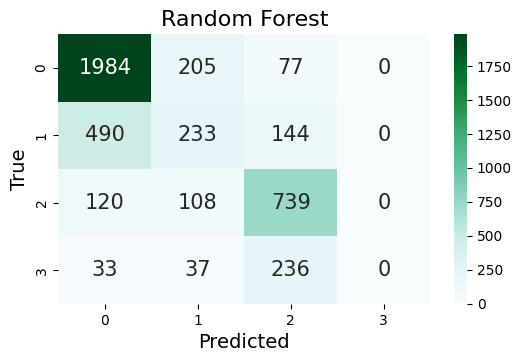

In [92]:
cm = confusion_matrix(y_test, rf2_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Random Forest', fontsize=16)
plt.show()

2. XGBoost

In [93]:
d_train2 = xgb.DMatrix(data = X_train_ohe_scaled, label = y_train)

params = {'max_depth': hp.quniform("max_depth", 2, 20, 1),
          'gamma': hp.uniform ('gamma', 15, 30),
          'reg_lambda': hp.uniform('reg_lambda', 0, 1),
          'subsample': hp.uniform('subsample', 0.1, 1),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
          'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
          'n_estimators': 2000,
          'seed': seed
}

def xgb2_goal(params):
  model = XGBClassifier(
    objective = 'multi:softprob',
    num_class = 4,
    eval_metric = ['merror', 'mlogloss', 'auc'],
    n_estimators = int(params['n_estimators']),
    learning_rate = 0.01,
    max_depth = int(params['max_depth']),
    min_child_weight = int(params['min_child_weight']),
    gamma = params['gamma'],
    subsample = params['subsample'],
    colsample_bytree = params['colsample_bytree'],
    early_stopping_rounds = 50,
    reg_alpha = 0,
    reg_lambda = params['reg_lambda'],
    random_state = seed
  )

  xgb_cv_results_df = xgb.cv(
    params = model.get_xgb_params(),
    dtrain = d_train2,
    nfold = 5,
    num_boost_round = model.get_params()['n_estimators'],
    early_stopping_rounds = model.get_params()['early_stopping_rounds'],
    seed = seed
  )

  best_score = min(xgb_cv_results_df['test-merror-mean'])
  best_round = len(xgb_cv_results_df)

  return {'loss': best_score, 'best_round': best_round, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = xgb2_goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate = np.random.default_rng(seed))

print("Best Hyperparameters:", best_hyperparams)
print(f"Best round (with early stopping applied): {trials.best_trial['result']['best_round']}")

100%|██████████| 100/100 [50:18<00:00, 30.18s/trial, best loss: 0.3195052527350448]
Best Hyperparameters: {'colsample_bytree': np.float64(0.9871222140098608), 'gamma': np.float64(15.847884926939509), 'max_depth': np.float64(13.0), 'min_child_weight': np.float64(8.0), 'reg_lambda': np.float64(0.5361447169880288), 'subsample': np.float64(0.9853987026131698)}
Best round (with early stopping applied): 629


In [94]:
xgb2_clf1 = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=12,
    min_child_weight=7,
    gamma=15.01,
    subsample=0.992,
    colsample_bytree=0.9586,
    reg_alpha=0,
    reg_lambda=0.73985,
    early_stopping_rounds=50,
    random_state=seed
    )

model = xgb2_clf1

xgb2_cv_results_df1 = xgb.cv(
    model.get_xgb_params(),
    d_train2,
    nfold=5,
    num_boost_round=model.get_params()['n_estimators'],
    early_stopping_rounds=model.get_params()['early_stopping_rounds'],
    seed=seed
)

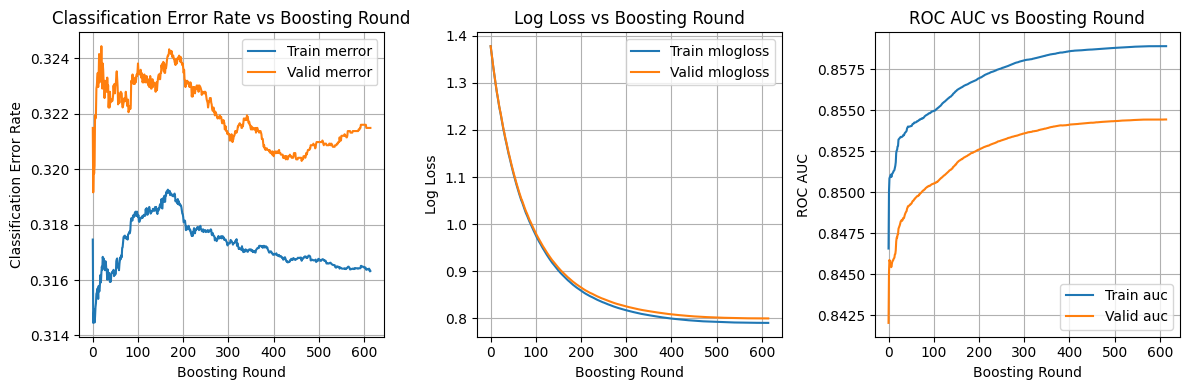

In [95]:
xgb_eval_plots(xgb2_cv_results_df1)

In [96]:
dftmp = xgb2_cv_results_df1
dftmp.loc[[dftmp['test-merror-mean'].idxmin(), 
           dftmp['test-mlogloss-mean'].idxmin(), 
           dftmp['test-auc-mean'].idxmax()],
 ['train-merror-mean', 'test-merror-mean', 
  'train-mlogloss-mean', 'test-mlogloss-mean', 
  'train-auc-mean', 'test-auc-mean']]

,train-merror-mean,test-merror-mean,train-mlogloss-mean,test-mlogloss-mean,train-auc-mean,test-auc-mean
1,0.314454,0.319165,1.370150,1.370303,0.850072,0.845137
614,0.316327,0.321492,0.789917,0.799404,0.858920,0.854451
614,0.316327,0.321492,0.789917,0.799404,0.858920,0.854451


In [97]:
tmp = 610
dftmp = xgb2_cv_results_df1
print(dftmp.loc[tmp,['train-merror-mean', 'test-merror-mean', 
                     'train-mlogloss-mean', 'test-mlogloss-mean', 
                     'train-auc-mean', 'test-auc-mean']])
print(1 - xgb2_cv_results_df1.loc[tmp, ['train-merror-mean', 'test-merror-mean']])

train-merror-mean      0.316384
test-merror-mean       0.321492
train-mlogloss-mean    0.789946
test-mlogloss-mean     0.799432
train-auc-mean         0.858921
test-auc-mean          0.854450
Name: 610, dtype: float64
train-merror-mean    0.683616
test-merror-mean     0.678508
Name: 610, dtype: float64


In [98]:
xgb2_final = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=610,
    learning_rate=0.01,
    max_depth=12,
    min_child_weight=7,
    gamma=15.01,
    subsample=0.992,
    colsample_bytree=0.9586,
    reg_alpha=0,
    reg_lambda=0.73985,
    # early_stopping_rounds=50,
    random_state=seed
    )

print(xgb2_final.get_xgb_params())

xgb2_final.fit(X_train_ohe_scaled, y_train)

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9586, 'device': None, 'eval_metric': ['merror', 'mlogloss', 'auc'], 'gamma': 15.01, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 12, 'max_leaves': None, 'min_child_weight': 7, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 57, 'reg_alpha': 0, 'reg_lambda': 0.73985, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.992, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9586, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=['merror', 'mlogloss', 'auc'], feature_types=None,
              feature_weights=None, gamma=15.01, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=610,
              n_jobs=None, num_class=4, ...)

In [99]:
# Save the model
with open('./temp/02_xgboost_no_sampling.pkl', 'wb') as f:
  pickle.dump(xgb2_final, f)

In [100]:
# Load the model
with open('./temp/02_xgboost_no_sampling.pkl', 'rb') as f:
  xgb2_final = pickle.load(f)

In [101]:
xgb2_train_pred, xgb2_test_pred = \
    report_for_model1(xgb2_final, X_train_ohe_scaled, y_train, X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      9064
           1       0.48      0.14      0.22      3466
           2       0.63      0.80      0.71      3869
           3       0.35      0.03      0.05      1222

    accuracy                           0.69     17621
   macro avg       0.55      0.48      0.45     17621
weighted avg       0.64      0.69      0.62     17621


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.73      0.93      0.81      2266
           1       0.45      0.13      0.21       867
           2       0.60      0.77      0.68       967
           3       0.45      0.03      0.06       306

    accuracy                           0.67      4406
   macro avg       0.56      0.47      0.44      4406
weighted avg       0.63      0.67      0.61      4406



In [102]:
report_for_model2(xgb2_final, 
                  X_train_ohe_scaled, y_train, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(xgb2_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score     support
0               0.73254  0.93612   0.82191   9064.0000
1               0.48473  0.14195   0.21959   3466.0000
2               0.63097  0.80253   0.70648   3869.0000
3               0.35294  0.02946   0.05438   1222.0000
accuracy        0.68770  0.68770   0.68770      0.6877
macro avg       0.55029  0.47752   0.45059  17621.0000
weighted avg    0.63517  0.68770   0.62487  17621.0000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.72699  0.92718   0.81497  2266.00000
1               0.45000  0.13495   0.20763   867.00000
2               0.60454  0.77146   0.67787   967.00000
3               0.45455  0.03268   0.06098   306.00000
accuracy        0.67499  0.67499   0.67499     0.67499
macro avg       0.55902  0.46657   0.44036  4406.00000
weighted avg    0.62669  0.67499   0.61301  4406.00000

--- Area Under the Recei

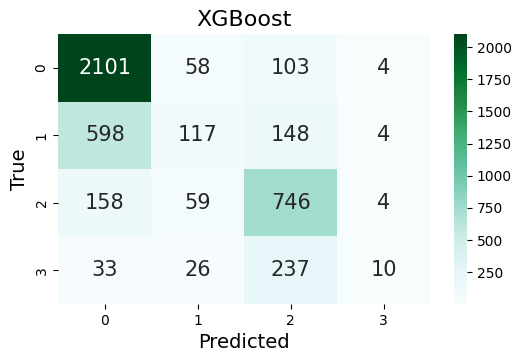

In [103]:
cm = confusion_matrix(y_test, xgb2_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('XGBoost', fontsize=16)
plt.show()

3. Logistic regression

In [104]:
mlogit2 = LogisticRegression(max_iter=1000, random_state=seed)

In [105]:
penalty_list = ['l2']
solver_list = ['lbfgs', 'newton-cg', 'sag', 'saga']

params = {
    'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
    'penalty': hp.choice('penalty', penalty_list),
    'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
    'random_state': seed
}

def mlogit2_goal(params):
    model = LogisticRegression(
        C = params['C'],
        penalty = params['penalty'],
        solver = params['solver'],
        max_iter = 1000,
        random_state = params['random_state']
    )

    cv_results = cross_validate(model, X_train_ohe_scaled, y_train,
                                cv = cv, scoring = 'accuracy',
                                return_train_score = True)

    val_acc = np.mean(cv_results['test_score'])
    train_acc = np.mean(cv_results['train_score'])

    return {'loss': -val_acc, 'status': STATUS_OK,
            'train_accuracy': train_acc, 'val_accuracy': val_acc}

trials = Trials()

best_hyperparams = fmin(fn = mlogit2_goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate = np.random.default_rng(seed))

print("Best Hyperparameters:", best_hyperparams)
print(f"  penalty: {penalty_list[best_hyperparams['penalty']]}")
print(f"  solver: {solver_list[best_hyperparams['solver']]}")
print(f"Best Train Accuracy: {trials.best_trial['result']['train_accuracy']}")
print(f"Best Validation Accuracy: {trials.best_trial['result']['val_accuracy']}")

100%|██████████| 100/100 [01:46<00:00,  1.06s/trial, best loss: -0.6778848825882903]
Best Hyperparameters: {'C': np.float64(11.658777188522913), 'penalty': np.int64(0), 'solver': np.int64(2)}
  penalty: l2
  solver: sag
Best Train Accuracy: 0.6814029258686591
Best Validation Accuracy: 0.6778848825882903


In [106]:
mlogit2_gsearch1 = GridSearchCV(
    param_grid={'solver': ['sag'],
                'penalty': ['l2'],
                'C': [12]},
    estimator=mlogit2,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True
)

mlogit2_gsearch1.fit(X_train_ohe_scaled, y_train)

mlogit2_cv_results_df1 = cv_results(mlogit2_gsearch1)
mlogit2_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,12,l2,sag,1,0.681403,0.677885,1,-0.782591,-0.789803,1,0.847508,0.843754,0.003518,0.007211,0.003754


In [107]:
print(mlogit2_gsearch1.best_params_)

mlogit2_final = mlogit2_gsearch1.best_estimator_
mlogit2_final.fit(X_train_ohe_scaled, y_train)

{'C': 12, 'penalty': 'l2', 'solver': 'sag'}


LogisticRegression(C=12, max_iter=1000, random_state=57, solver='sag')

In [108]:
# Save the model
with open('./temp/03_logistic_regression_no_sampling.pkl', 'wb') as f:
  pickle.dump(mlogit2_final, f)

In [109]:
# Load the model
with open('./temp//03_logistic_regression_no_sampling.pkl', 'rb') as f:
  mlogit2_final = pickle.load(f)

In [110]:
mlogit2_train_pred, mlogit2_test_pred = \
    report_for_model1(mlogit2_final, X_train_ohe_scaled, y_train, X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      9064
           1       0.42      0.19      0.26      3466
           2       0.65      0.74      0.69      3869
           3       0.47      0.11      0.18      1222

    accuracy                           0.68     17621
   macro avg       0.57      0.49      0.49     17621
weighted avg       0.64      0.68      0.64     17621


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2266
           1       0.41      0.18      0.25       867
           2       0.63      0.74      0.68       967
           3       0.49      0.12      0.19       306

    accuracy                           0.68      4406
   macro avg       0.57      0.49      0.48      4406
weighted avg       0.63      0.68      0.63      4406



In [111]:
report_for_model2(mlogit2_final, 
                  X_train_ohe_scaled, y_train, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(mlogit2_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score     support
0               0.73577  0.92101   0.81803   9064.0000
1               0.41769  0.18667   0.25803   3466.0000
2               0.64883  0.74257   0.69254   3869.0000
3               0.46644  0.11375   0.18289   1222.0000
accuracy        0.68140  0.68140   0.68140      0.6814
macro avg       0.56718  0.49100   0.48787  17621.0000
weighted avg    0.63543  0.68140   0.63628  17621.0000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.73253  0.91615   0.81412  2266.00000
1               0.41444  0.17878   0.24980   867.00000
2               0.63402  0.73630   0.68134   967.00000
3               0.49333  0.12092   0.19423   306.00000
accuracy        0.67635  0.67635   0.67635     0.67635
macro avg       0.56858  0.48804   0.48487  4406.00000
weighted avg    0.63171  0.67635   0.63088  4406.00000

--- Area Under the Recei

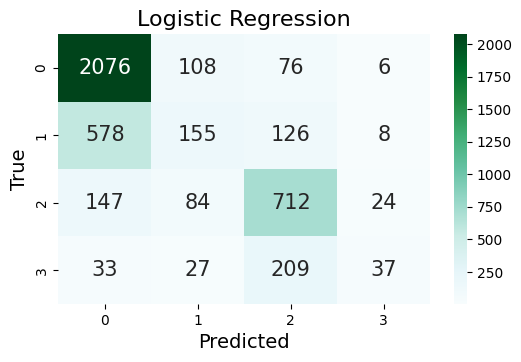

In [112]:
cm = confusion_matrix(y_test, mlogit2_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Logistic Regression', fontsize=16)
plt.show()

4. SVM

In [6]:
svc2 = SVC(probability=True, random_state=seed)

In [7]:
class_counts = pd.Series(y_train).value_counts().sort_index()
print(class_counts)

sampling_strategy = {
    cls: max(1, int(count * 0.10)) for cls, count in class_counts.items()
}
print(sampling_strategy)

rus_3 = RandomUnderSampler(sampling_strategy = sampling_strategy, 
                           random_state = seed)

X_train_ohe_scaled_rus_3, y_train_rus_3 = rus_3.fit_resample(X_train_ohe_scaled, y_train)

COMPOSITE_HI2
0    9064
1    3466
2    3869
3    1222
Name: count, dtype: int64
{0: 906, 1: 346, 2: 386, 3: 122}


In [8]:
kernel_list = ['linear', 'rbf', 'poly', 'sigmoid']

params = {
    'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
    'kernel': hp.choice('kernel', kernel_list),
    'gamma': hp.loguniform('gamma', np.log(0.001), np.log(1000)), 
    'coef0': hp.uniform('coef0', 0, 10),
    'degree': hp.quniform('degree', 1, 5, 1), 
    'random_state': seed
}

def svm2_goal(params):
    model = SVC(
        C=params['C'],
        kernel=params['kernel'],
        gamma=params['gamma'],
        coef0=params['coef0'],
        degree=int(params['degree']),
        random_state=params['random_state'],
        probability=True
    )

    cv_results = cross_validate(model, X_train_ohe_scaled_rus_3, y_train_rus_3,
                                cv=cv, scoring='accuracy',
                                return_train_score=True)

    val_acc = np.mean(cv_results['test_score'])
    train_acc = np.mean(cv_results['train_score'])

    return {'loss': -val_acc, 'status': STATUS_OK,
            'train_accuracy': train_acc, 'val_accuracy': val_acc}

trials = Trials()

best_hyperparams = fmin(fn=svm2_goal,
                        space=params,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials,
                        rstate=np.random.default_rng(seed))

print("Best Hyperparameters:", best_hyperparams)
print(f"  kernel: {kernel_list[best_hyperparams['kernel']]}")

100%|██████████| 100/100 [45:47<00:00, 27.48s/trial, best loss: -0.6528409090909091]  
Best Hyperparameters: {'C': np.float64(7.413857958156227), 'coef0': np.float64(3.116664108688032), 'degree': np.float64(5.0), 'gamma': np.float64(0.003766857259220819), 'kernel': np.int64(0)}
  kernel: linear


In [9]:
svc2_gsearch1 = GridSearchCV(
    param_grid={'kernel': ['linear'],
                'C': [7.413859],
                'gamma': [0.003767]},
    estimator=svc2,
    cv=cv,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc2_gsearch1.fit(X_train_ohe_scaled, y_train)

svc2_cv_results_df1 = cv_results(svc2_gsearch1)
svc2_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,7.413859,0.003767,linear,1,0.669954,0.667102,1,-0.794361,-0.801162,1,0.840938,0.837069,0.002852,0.006801,0.003869


In [10]:
print(svc2_gsearch1.best_params_)

svc2_final = svc2_gsearch1.best_estimator_
svc2_final.fit(X_train_ohe_scaled, y_train)

{'C': 7.413859, 'gamma': 0.003767, 'kernel': 'linear'}


SVC(C=7.413859, gamma=0.003767, kernel='linear', probability=True,
    random_state=57)

In [11]:
# Save the model
with open('./temp/04_SVC_no_sampling.pkl', 'wb') as f:
  pickle.dump(svc2_final, f)

In [12]:
# Load the model
with open('./temp/04_SVC_no_sampling.pkl', 'rb') as f:
  svc2_final = pickle.load(f)

In [13]:
svc2_train_pred, svc2_test_pred = \
    report_for_model1(svc2_final, X_train_ohe_scaled, y_train, X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      9064
           1       0.35      0.03      0.06      3466
           2       0.64      0.75      0.69      3869
           3       0.00      0.00      0.00      1222

    accuracy                           0.67     17621
   macro avg       0.42      0.44      0.39     17621
weighted avg       0.56      0.67      0.58     17621


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      2266
           1       0.46      0.04      0.07       867
           2       0.62      0.75      0.68       967
           3       0.00      0.00      0.00       306

    accuracy                           0.67      4406
   macro avg       0.44      0.44      0.39      4406
weighted avg       0.58      0.67      0.57      4406



In [14]:
report_for_model2(svc2_final, 
                  X_train_ohe_scaled, y_train, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(svc2_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.68643  0.96414   0.80193   9064.00000
1               0.35161  0.03145   0.05773   3466.00000
2               0.63603  0.75291   0.68955   3869.00000
3               0.00000  0.00000   0.00000   1222.00000
accuracy        0.66744  0.66744   0.66744      0.66744
macro avg       0.41852  0.43712   0.38730  17621.00000
weighted avg    0.56190  0.66744   0.57526  17621.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.68630  0.96161   0.80096  2266.00000
1               0.46269  0.03576   0.06638   867.00000
2               0.62113  0.74767   0.67855   967.00000
3               0.00000  0.00000   0.00000   306.00000
accuracy        0.66568  0.66568   0.66568     0.66568
macro avg       0.44253  0.43626   0.38647  4406.00000
weighted avg    0.58033  0.66568   0.57392  4406.00000

--- Area Under t

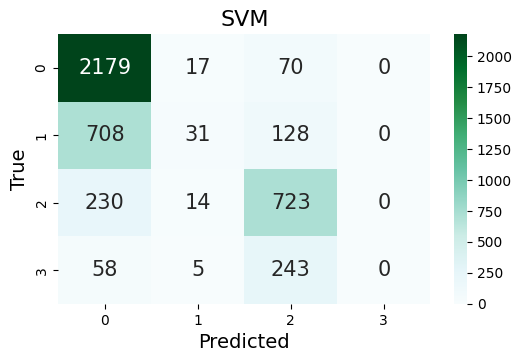

In [15]:
cm = confusion_matrix(y_test, svc2_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('SVM', fontsize=16)
plt.show()